# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

**Libs**

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
import os
from collections import deque

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import pandas as pd
from IPython.display import clear_output
import gdown
import zipfile
import optuna
from tqdm import tqdm

## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depthm map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [3]:
download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=66dcb637-8c10-430e-9e0b-8f316cab7bab
To: /home/my_notebooks/DLAV/project/Phase 2/dlav_train.zip
100%|██████████| 439M/439M [00:03<00:00, 124MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=4a71228b-5850-4d25-b13a-cc24522ff06b
To: /home/my_notebooks/DLAV/project/Phase 2/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:01<00:00, 84.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=18b2a001-d232-4e4a-b0bf-74cb0aa1da9f
To: /home/my_notebooks/DLAV/project/Phase 2/dlav_test_public.zip
100%|██████████

Now lets load the data and visualize the first few examples to see what we are dealing with!

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'sdc_future_feature', 'semantic_label'])


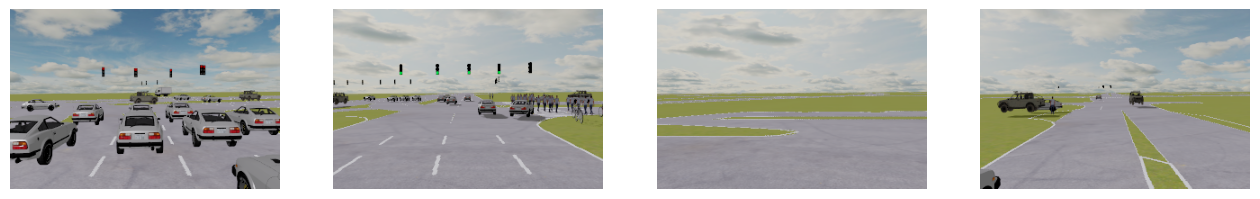

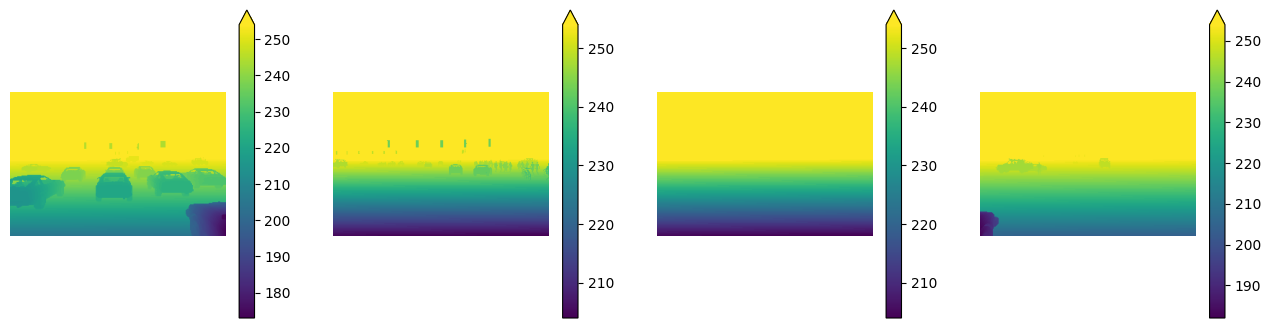

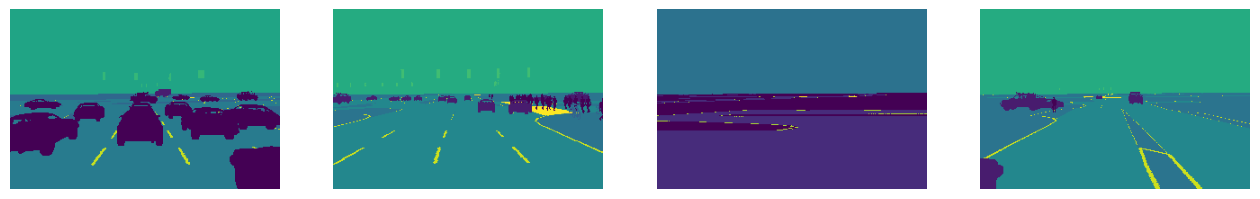

History shape: (21, 3)
Future shape: (60, 3)
Depth shape: (200, 300, 1)
Semantic shape: (200, 300)


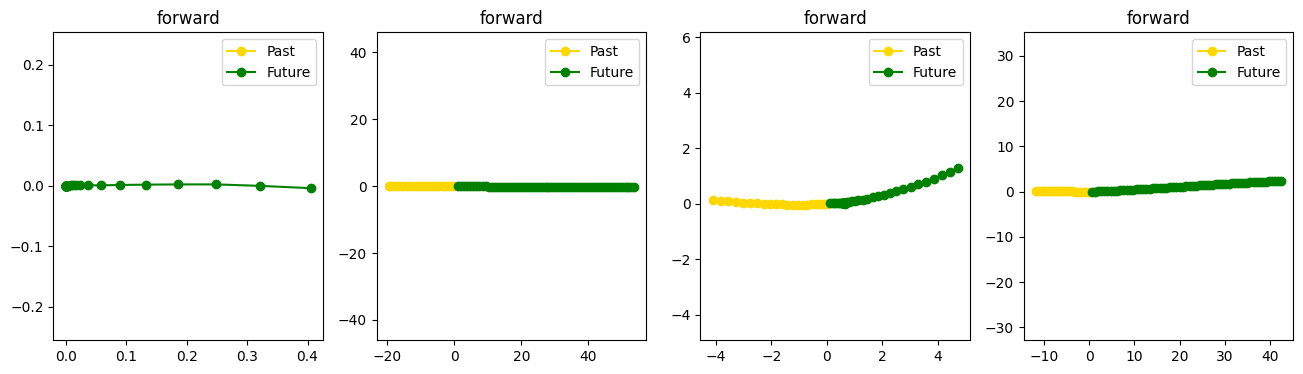

In [4]:
k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

print(data[0].keys())

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the depth view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    depth_map = axis[i].imshow(data[i]["depth"])
    fig.colorbar(depth_map, ax=axis[i], extend='max')
    axis[i].axis("off")
plt.show()

# plot the semantic_label view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["semantic_label"])
    axis[i].axis("off")
plt.show()


# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
    axis[i].set_title(data[i]["driving_command"])

print(f"History shape: {np.shape(data[0]['sdc_history_feature'])}")
print(f"Future shape: {np.shape(data[0]['sdc_future_feature'])}")
print(f"Depth shape: {np.shape(data[0]['depth'])}")
print(f"Semantic shape: {np.shape(data[0]['semantic_label'])}")
plt.show()

1. Dataset class which loads the data and does some basic preprocessing.


In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])
        semantic = torch.FloatTensor(data['semantic_label'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic,
                'future': future
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'semantic': semantic,
                'depth': depth
            }



2. The Logger which receives training metrics and logs and prints/visualizes them.

Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics.

In [6]:
class Logger:
    def __init__(self, base_dir="logs", run_prefix="run", save_every=100, plot_metrics=None, silent=True):
        self.base_dir = base_dir
        self.run_prefix = run_prefix
        self.save_every = save_every
        self.plot_metrics = plot_metrics
        self.silent = silent
        self.last_saved_step = -1
        self.history = {}
        self.latest_logs = deque(maxlen=10)
        self.figures = {}

        os.makedirs(self.base_dir, exist_ok=True)
        self.log_dir = self._create_unique_run_dir()
        os.makedirs(self.log_dir, exist_ok=True)

        if not self.silent:
            print(f"Logging to {self.log_dir}")

    def _create_unique_run_dir(self):
        i = 0
        while os.path.exists(os.path.join(self.base_dir, f"{self.run_prefix}_{i}")):
            i += 1
        return os.path.join(self.base_dir, f"{self.run_prefix}_{i}")

    def log(self, step=None, **metrics):
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v:.4f}" for k, v in metrics.items())
        log_entry = prefix + metric_str
        self.latest_logs.append(log_entry)

        if not self.silent:
            clear_output(wait=True)  # Clear notebook output
            for entry in self.latest_logs:
                print(entry)

        for key, value in metrics.items():
            if key not in self.history:
                self.history[key] = []
            self.history[key].append((step, value))

        if step is not None and (step - self.last_saved_step) >= self.save_every:
            self.plot(step)
            self.last_saved_step = step

    def plot(self, step=None):
        if not self.history:
            if not self.silent:
                print("No metrics to plot yet.")
            return

        for key, values in self.history.items():
            if self.plot_metrics is None or key in self.plot_metrics:
                steps, vals = zip(*values)

                if key not in self.figures:
                    fig, ax = plt.subplots(figsize=(8, 5))
                    self.figures[key] = (fig, ax)
                else:
                    fig, ax = self.figures[key]

                ax.clear()
                ax.plot(steps, vals, label=key, color='tab:blue')
                ax.set_xlabel("Step")
                ax.set_ylabel(key)
                ax.set_title(f"{key} over Steps")
                ax.grid(True)
                ax.legend()

                fig.tight_layout()

                plot_path = os.path.join(self.log_dir, f"{key}_plot.png")
                fig.savefig(plot_path)
                fig.canvas.draw()
                fig.canvas.flush_events()


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.


In [30]:
class BetterDrivingPlanner(nn.Module):
    def __init__(self, 
                 num_modes=6,
                 future_steps=60,
                 dropout_val=0,
                 use_layernorm=False,
                 use_depth_aux=False,
                 use_semantic_aux=False,
                 freeze_pretrained=False
                ):
    
        super().__init__()

        self.num_modes = num_modes
        self.future_steps = future_steps
        self.dropout_val = dropout_val
        self.use_layernorm = use_layernorm
        self.use_depth_aux = use_depth_aux
        self.use_semantic_aux = use_semantic_aux
        self.num_classes = 15

        # Visual encoder: ResNet18 pretrained
        # resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc layers
        # self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        # if self.use_layernorm:
        #     self.visual_fc = nn.Sequential(
        #         nn.Linear(512, 256),
        #         nn.LayerNorm(256)
        #     )
        # else:
        #     self.visual_fc = nn.Linear(512, 256)

        # Use a stronger visual encoder
        resnet = models.resnet34(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        # self.visual_fc = nn.Linear(512, 256)  # ResNet18 last conv outputs 512 channels
        self.visual_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_val)
        )

            
        if freeze_pretrained:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
            # Unfreeze the last block (layer4) and the final convolutional layer
            for name, param in self.visual_encoder.named_parameters():
                if "layer4" in name or "conv1" in name:
                    param.requires_grad = True

        # History encoder (maybe could use LSTM or GRU instead)
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 256),
            nn.ReLU(),
            nn.Dropout(dropout_val),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128) if use_layernorm else nn.Identity(),
            nn.Dropout(dropout_val)
        )
        
        # History encoder with LSTM
        # self.history_lstm = nn.LSTM(input_size=3, hidden_size=128, batch_first=True)



        # self.history_gru = nn.GRU(input_size=3, hidden_size=128, batch_first=True)



        # # Depth decoder 
        # if self.use_depth_aux: 
        #     # Shared decoder trunk
        #     self.depth_decoder_trunk = nn.Sequential(
        #         nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         nn.BatchNorm2d(256),
        #         nn.ReLU(),
        #         nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         nn.BatchNorm2d(64),
        #         nn.ReLU()
        #     )
        #     # Depth map prediction head
        #     self.depth_map_head = nn.Sequential(
        #         nn.Conv2d(64, 1, kernel_size=3, padding=1),
        #         nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)  # match input size
        #     )
        #     # Depth embedding head (for trajectory fusion)
        #     self.depth_embedding_head = nn.Sequential(
        #         nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
        #         nn.Flatten(),
        #         nn.Linear(64, 128)  # Can match semantic_embed dim
        #     )

        #Deeper depth decoder
        # if self.use_depth_aux:
        #     # Shared decoder trunk
        #     self.depth_decoder_trunk = nn.Sequential(
        #         nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         # nn.BatchNorm2d(512),
        #         # nn.ReLU(),
        #         # nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         nn.BatchNorm2d(256),
        #         nn.ReLU(),
        #         nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         nn.BatchNorm2d(128),
        #         nn.ReLU(),
        #         nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         nn.BatchNorm2d(64),
        #         nn.ReLU()
        #     )
        #     # Depth map prediction head
        #     self.depth_map_head = nn.Sequential(
        #         nn.Conv2d(64, 32, kernel_size=3, padding=1),
        #         nn.ReLU(),
        #         nn.Conv2d(32, 1, kernel_size=3, padding=1),
        #         nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)  # match input size
        #     )
        #     # Depth embedding head (for trajectory fusion)
        #     self.depth_embedding_head = nn.Sequential(
        #         nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
        #         nn.Flatten(),
        #         nn.Linear(64, 128),  # Increased to 256 units for better representation
        #         # nn.ReLU(),
        #         # nn.Linear(256, 128)  # Keep a connection to the semantic_embed dim
        #     )

        if self.use_depth_aux:
            self.depth_decoder_trunk = nn.Sequential(
                nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            )
            self.depth_map_head = nn.Sequential(
                nn.Conv2d(128, 1, kernel_size=3, padding=1),
                nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
            )

            
        # # Semantic decoder 
        # if self.use_semantic_aux:
        #     # Shared decoder trunk
        #     self.semantic_decoder_trunk = nn.Sequential(
        #         nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         nn.BatchNorm2d(256),
        #         nn.ReLU(),
        #         nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        #         nn.BatchNorm2d(64),
        #         nn.ReLU()
        #     )
        #     # Segmentation output head
        #     self.semantic_logits_head = nn.Sequential(
        #         nn.Conv2d(64, self.num_classes, kernel_size=1),  # logits
        #         nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
        #     )
        #     # Embedding head (for trajectory fusion)
        #     self.semantic_embedding_head = nn.Sequential(
        #         nn.AdaptiveAvgPool2d((1, 1)),  # global pooling
        #         nn.Flatten(),
        #         nn.Linear(64, 128)  # Embedding size
        #     )

        #Deeper semantic decoder
        if self.use_semantic_aux:
            # Shared decoder trunk
            self.semantic_decoder_trunk = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                # nn.BatchNorm2d(512),
                # nn.ReLU(),
                # nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU()
            )
        
            # Segmentation output head
            self.semantic_logits_head = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, self.num_classes, kernel_size=1),  # logits
                nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)  # match input size
            )
        
            # Embedding head (for trajectory fusion)
            self.semantic_embedding_head = nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),  # global pooling
                nn.Flatten(),
                # nn.Linear(64, 128),  # Increased size for more complex representation
                # nn.ReLU(),
                # nn.Linear(256, 128)  # Matching semantic embed dimension
            )

        

        # Fusion MLP with optional Dropout for stabilization
        fusion_input_size = 256 + 128
        # if self.use_depth_aux:
        #     fusion_input_size += 128
        # if self.use_semantic_aux:
        #     fusion_input_size += 128

        # self.fusion = nn.Sequential(
        #     nn.Linear(fusion_input_size, 512),
        #     nn.ReLU(),
        #     nn.LayerNorm(512),
        #     nn.Dropout(self.dropout_val)
        # )

        # self.fusion = nn.Sequential(
        #     nn.Linear(fusion_input_size, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 512),
        #     nn.ReLU()
        # )
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_size, 512),
            nn.ReLU(),
            nn.LayerNorm(512) if use_layernorm else nn.Identity(),
            nn.Dropout(dropout_val),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.LayerNorm(512) if use_layernorm else nn.Identity(),
            nn.Dropout(dropout_val)
        )
        
        # self.transformer_layer = nn.TransformerEncoderLayer(
        #     d_model=512, 
        #     nhead=8, 
        #     dim_feedforward=1024, 
        #     dropout=self.dropout_val
        # )
        # self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=3)

        
        # Trajectory decoder
        # Predict K trajectories + confidence scores
        self.trajectory_head = nn.Linear(512, self.num_modes * self.future_steps * 3)  # (x, y) only, no heading
        self.confidence_head = nn.Linear(512, self.num_modes)  # One confidence score per mode

 
    def forward(self, camera, history):
        batch_size = camera.size(0)

        # Encode camera image
        visual_encoded = self.visual_encoder(camera)  # (B, 512, H', W')
        visual_features = self.visual_pool(visual_encoded).view(batch_size, -1)  # (B, 512)
        visual_features = self.visual_fc(visual_features)  # (B, 256)
        # visual_features = self.visual_pool(visual_encoded).view(batch_size, -1)  # (B, 512)
        # visual_features = self.visual_fc(visual_encoded)  # (B, 256)

        # Encode history
        history_flat = history.reshape(batch_size, -1)
        history_features = self.history_encoder(history_flat)  # (B, 128)
        
        # _, history_features = self.history_gru(history)  # history: (B, 21, 3)  # if using 
        # history_features = history_features.squeeze(0)  # (B, 128)
        
        # _, (history_features, _) = self.history_lstm(history)
        # history_features = history_features.squeeze(0)  # (B, 128)



        # Optional auxiliary outputs & embeddings
        fusion_inputs = [visual_features, history_features]

        depth_out = None
        if self.use_depth_aux:
            # Shared semantic decoding
            depth_features = self.depth_decoder_trunk(visual_encoded)
            # Depth prediction (for loss)
            depth_out = self.depth_map_head(depth_features).permute(0, 2, 3, 1)
            # Depth embedding (for fusion)
            # depth_embed = self.depth_embedding_head(depth_features)  # (B, 128)
            # fusion_inputs.append(depth_embed)

        semantic_out = None
        if self.use_semantic_aux:
            # Shared semantic decoding
            semantic_features = self.semantic_decoder_trunk(visual_encoded)
            # Semantic prediction (for loss)
            semantic_out = self.semantic_logits_head(semantic_features).permute(0, 2, 3, 1)
            # Semantic embedding (for fusion)
            semantic_embed = self.semantic_embedding_head(semantic_features)  # (B, 128)
            # fusion_inputs.append(semantic_embed)

        # Fuse features
        fused = torch.cat(fusion_inputs, dim=-1)
        fused = self.fusion(fused)  # (B, 512)

        # # Add a batch dimension for the transformer (B, S, D) -> (S, B, D)
        # fused = fused.unsqueeze(0)
        
        # # Transformer encoder
        # fused = self.transformer_encoder(fused)  # (S, B, D)
        # fused = fused.squeeze(0)  # Remove the sequence dimension

        # Predict trajectory
        traj = self.trajectory_head(fused)  # (B, num_modes * future_steps * 2)
        traj = traj.view(batch_size, self.num_modes, self.future_steps, 3)

        conf = self.confidence_head(fused)  # (B, num_modes)
        # conf = torch.softmax(conf, dim=-1)  # Confidence scores across modes
        conf = nn.functional.gumbel_softmax(self.confidence_head(fused), tau=1, hard=True)

       
        return traj, conf, depth_out, semantic_out

    def predict_best(self, traj, conf):
        """
        Given predicted trajectories and confidence scores,
        select the most probable trajectory.
        """
        best_idx = conf.argmax(dim=1)  # (B,)
        batch_size = traj.size(0)
        best_traj = traj[torch.arange(batch_size), best_idx]  # (B, future_steps, 2)
        return best_traj



## 🚀 Trainer with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [19]:
def train(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler=None, 
    logger=None, 
    num_epochs=50,
    lambda_depth=0.1,
    lambda_semantic=0.1
):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.SmoothL1Loss(reduction='none')  # L1 loss for better robustness
    scaler = GradScaler()  # for mixed precision

    # Define augmentation and normalization transforms
    # augmentations = T.Compose([
    #     T.RandomHorizontalFlip(p=0.5),
    #     T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #     T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    # ])

    # normalize = T.Compose([
    #     T.ConvertImageDtype(torch.float),  # ensure float tensor
    #     T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
    #                 std=[0.229, 0.224, 0.225])   # ImageNet stds
    # ])

    best_val_ade = float("inf")

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)):
            camera = batch['camera'].to(device)    # (B, 3, H, W)
            history = batch['history'].to(device)  # (B, T, 3)
            future = batch['future'].to(device)    # (B, T, 3)
            depth = batch['depth'].to(device)    # (B, 1, H, W) ?
            semantic = batch['semantic'].to(device)    # (B, H, W) ?

            optimizer.zero_grad()

            # Apply augmentations only during training
            # camera = torch.stack([augmentations(img) for img in camera])

            # Always normalize
            # camera = normalize(camera)

            with autocast('cuda'):  # mixed precision
                traj_pred, conf_pred, depth_pred, semantic_pred = model(camera, history)  # (B, num_modes, T, 2), (B, num_modes), ...

                # Expand ground truth to match modes
                future_expand = future[:, None, :, :].expand_as(traj_pred)

                # Compute loss for each mode
                loss_per_mode = criterion(traj_pred, future_expand).mean(dim=[2,3])  # (B, num_modes)
                weighted_traj_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()

                total_loss = weighted_traj_loss
                # Depth loss
                depth_loss = {}
                if depth_pred is not None:
                    # normalized_depth = 
                    depth_loss = lambda_depth * F.smooth_l1_loss(depth_pred, depth)  # Maybe change loss ? 
                    total_loss += depth_loss

                # Semantic Loss
                semantic_loss = {}
                if semantic_pred is not None:
                    semantic_loss = lambda_semantic * F.cross_entropy(
                            semantic_pred.permute(0, 3, 1, 2),  # Convert to [B, C, H, W]
                            semantic.long()  # Ground truth labels: [B, H, W]
                        )                    
                    total_loss += semantic_loss

 
            scaler.scale(total_loss).backward()

            # Gradient clipping (optional but safer)
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            scaler.step(optimizer)
            scaler.update()

            # Logging
            if idx % 10 == 0 and logger is not None:
                log_data = {
                    'total_loss': total_loss.item(),
                    'weighted_traj_loss': weighted_traj_loss.item()
                }
                
                if depth_pred is not None:
                    log_data['depth_loss'] = depth_loss.item()
                if semantic_pred is not None:
                    log_data['semantic_loss'] = semantic_loss.item()
                
                logger.log(step=epoch * len(train_loader) + idx, **log_data)
                                    
            
            train_loss += total_loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)

                # Only normalize (no augmentations during validation)
                # camera = normalize(camera)
                
                traj_pred, conf_pred,_ ,_ = model(camera, history)
                best_traj = model.predict_best(traj_pred, conf_pred)

                ADE = torch.norm(best_traj[..., :2] - future[..., :2], dim=-1).mean()
                FDE = torch.norm(best_traj[:, -1, :2] - future[:, -1, :2], dim=-1).mean()
                loss = criterion(best_traj[..., :2], future[..., :2]).mean()

                ade_all.append(ADE.item())
                fde_all.append(ADE.item())
                val_loss += loss.item()

        current_ade = np.mean(ade_all)
        
        if scheduler is not None:
            scheduler.step()  

        if current_ade < best_val_ade:
            best_val_ade = current_ade
        

        # logger.log(step=epoch,
        #            train_loss=train_loss / len(train_loader),
        #            val_loss=val_loss / len(val_loader),
        #            ADE=np.mean(ade_all),
        #            FDE=np.mean(fde_all))

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f} | "
              f"ADE: {np.mean(ade_all):.4f} | FDE: {np.mean(fde_all):.4f}")

    return best_val_ade


## 🗂️ Data Loader

In [9]:
train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)


# Data augmentation

Augmented training data already exists. Skipping augmentation.
Loaded 639.pkl
Loaded flipped_639.pkl
Loaded 25.pkl
Loaded flipped_25.pkl
Loaded 275.pkl
Loaded flipped_275.pkl
Loaded 223.pkl
Loaded flipped_223.pkl


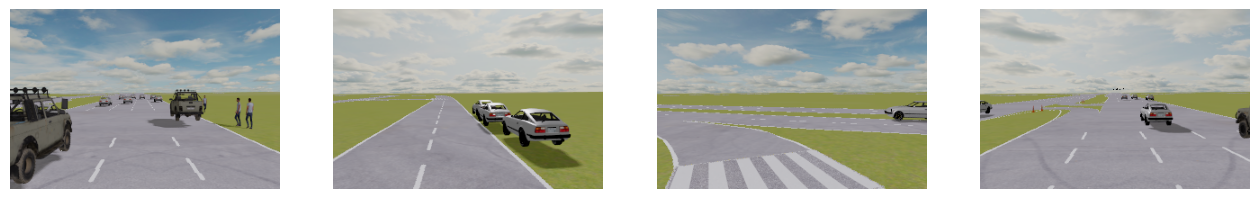

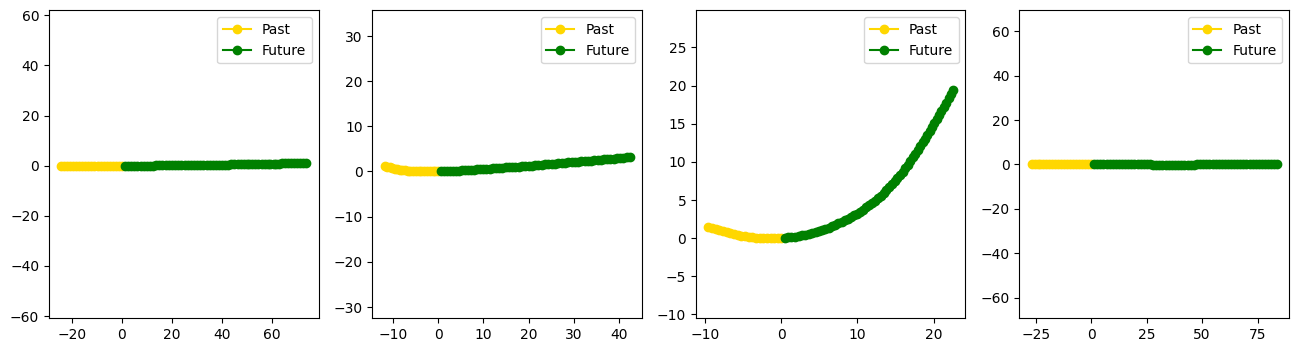

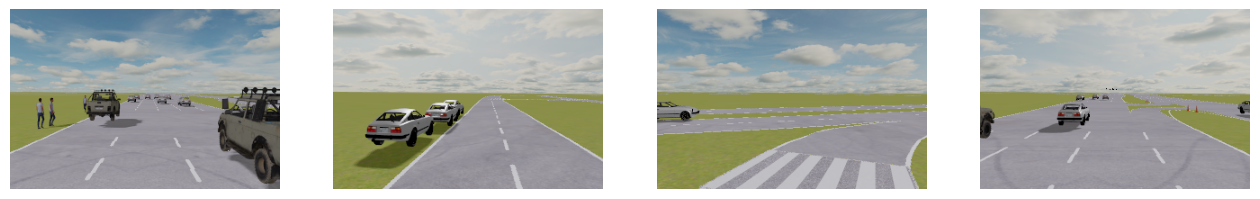

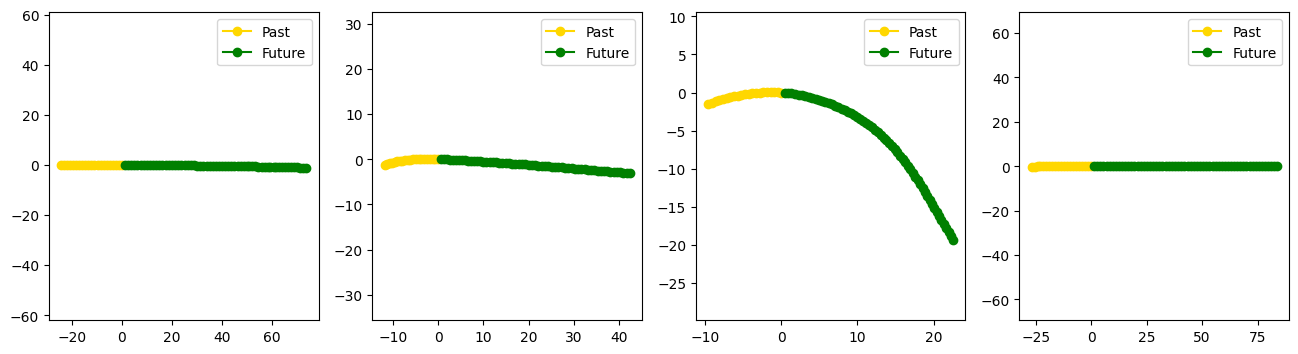

In [10]:
def augment_and_save(file_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    for file_path in tqdm(file_list):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Flip image horizontally
        camera = data['camera'][:, ::-1, :]  # shape HxWxC, flip width

        # Flip signs for 2nd and 3rd cols in history and future
        data['camera'] = camera
        data['sdc_history_feature'][:, 1:] *= -1

        if 'sdc_future_feature' in data:
            data['sdc_future_feature'][:, 1:] *= -1

        # Save to new file
        base = os.path.basename(file_path)
        new_path = os.path.join(save_dir, f"flipped_{base}")
        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

if not os.path.exists('augmented_train'):
    augmented_train = augment_and_save(train_files, save_dir='augmented_train')
else:
    print("Augmented training data already exists. Skipping augmentation.")

augmented_train_files = [os.path.join("augmented_train", f) for f in os.listdir("augmented_train") if f.endswith('.pkl')]
# Create augmented datasets
augmented_train_dataset = DrivingDataset(augmented_train_files)

# load k data from augmented_samples
aug_data = []
data = []
k = 4
# load the data
for i in random.choices(np.arange(1000), k=k):
    with open(f".//train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))
        print(f"Loaded {i}.pkl")
    with open(f".//augmented_train/flipped_{i}.pkl", "rb") as f:
        aug_data.append(pickle.load(f))
        print(f"Loaded flipped_{i}.pkl")


# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(aug_data[i]["camera"])
    axis[i].axis("off")
plt.show()

fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(aug_data[i]["sdc_history_feature"][:, 0], aug_data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(aug_data[i]["sdc_future_feature"][:, 0], aug_data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()



## 🧪 Hyperparam Tuning

In [20]:
def build_model_from_trial(trial):
    # Suggested hyperparameters
    dropout_val = trial.suggest_float("dropout", 0.0, 0.3)
    use_layernorm = trial.suggest_categorical("use_layernorm", [True, False])

    num_modes=6
    future_steps=60

    # You could pass these as args or set them globally
    model = BetterDrivingPlanner(
        num_modes=num_modes,
        future_steps=future_steps,
        dropout_val=dropout_val,
        use_layernorm=use_layernorm,
        use_depth_aux=True,
        use_semantic_aux=False
    )
    return model
    
def objective(trial):
    # Search space
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    # scheduler_factor = trial.suggest_float("scheduler_factor", 0.5, 0.95)
    # scheduler_patience = trial.suggest_int("scheduler_patience", 2, 5)

    model = build_model_from_trial(trial)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience
    # )

    best_val_ade = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        # scheduler=scheduler,
        logger=None,  # optionally disable during tuning
        num_epochs=7,  # fewer epochs during tuning
    )

    return best_val_ade

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

import optuna.visualization as vis

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_parallel_coordinate(study).show()

[I 2025-05-14 19:37:42,981] A new study created in memory with name: no-name-6e58d412-4fe4-47e3-a283-36f9f21c6947
/tmp/ipykernel_1640/1496449097.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
                                                          

[Epoch 1/7] Train Loss: 28.4810 | Val Loss: 6.5283 | ADE: 13.0256 | FDE: 13.0256


[Epoch 2/7] Train Loss: 27.1255 | Val Loss: 5.6857 | ADE: 11.3709 | FDE: 11.3709


[Epoch 3/7] Train Loss: 25.1216 | Val Loss: 5.1795 | ADE: 10.3782 | FDE: 10.3782


[Epoch 4/7] Train Loss: 22.7993 | Val Loss: 4.8250 | ADE: 9.6882 | FDE: 9.6882


[Epoch 5/7] Train Loss: 20.2173 | Val Loss: 4.5205 | ADE: 9.0895 | FDE: 9.0895


[Epoch 6/7] Train Loss: 17.2986 | Val Loss: 4.2772 | ADE: 8.6207 | FDE: 8.6207


[I 2025-05-14 19:39:42,478] Trial 0 finished with value: 8.148163437843323 and parameters: {'lr': 3.514114404014295e-05, 'weight_decay': 1.4148832182273242e-05, 'dropout': 0.1297018262391728, 'use_layernorm': True}. Best is trial 0 with value: 8.148163437843323.


[Epoch 7/7] Train Loss: 14.0387 | Val Loss: 4.0274 | ADE: 8.1482 | FDE: 8.1482


[Epoch 1/7] Train Loss: 25.2270 | Val Loss: 4.4088 | ADE: 8.8708 | FDE: 8.8708


[Epoch 2/7] Train Loss: 10.6351 | Val Loss: 3.4873 | ADE: 7.1158 | FDE: 7.1158


[Epoch 3/7] Train Loss: 2.1312 | Val Loss: 1.7772 | ADE: 3.6872 | FDE: 3.6872


[Epoch 4/7] Train Loss: 1.5119 | Val Loss: 1.3279 | ADE: 2.8500 | FDE: 2.8500


[Epoch 5/7] Train Loss: 1.2751 | Val Loss: 1.2054 | ADE: 2.6069 | FDE: 2.6069


[Epoch 6/7] Train Loss: 1.0998 | Val Loss: 1.1584 | ADE: 2.5375 | FDE: 2.5375


[I 2025-05-14 19:41:42,738] Trial 1 finished with value: 2.4801385775208473 and parameters: {'lr': 0.00020104881692869508, 'weight_decay': 1.0904547270318069e-05, 'dropout': 0.23648739575318653, 'use_layernorm': True}. Best is trial 1 with value: 2.4801385775208473.


[Epoch 7/7] Train Loss: 0.9116 | Val Loss: 1.1411 | ADE: 2.4801 | FDE: 2.4801


[Epoch 1/7] Train Loss: 28.0032 | Val Loss: 6.1611 | ADE: 12.2997 | FDE: 12.2997


[Epoch 2/7] Train Loss: 25.1741 | Val Loss: 5.2954 | ADE: 10.5998 | FDE: 10.5998


[Epoch 3/7] Train Loss: 21.4966 | Val Loss: 4.7646 | ADE: 9.5910 | FDE: 9.5910


[Epoch 4/7] Train Loss: 17.0835 | Val Loss: 4.3561 | ADE: 8.7767 | FDE: 8.7767


[Epoch 5/7] Train Loss: 11.7723 | Val Loss: 4.0219 | ADE: 8.1263 | FDE: 8.1263


[Epoch 6/7] Train Loss: 5.6632 | Val Loss: 3.7065 | ADE: 7.4984 | FDE: 7.4984


[I 2025-05-14 19:43:42,405] Trial 2 finished with value: 5.910905510187149 and parameters: {'lr': 5.2421508479652784e-05, 'weight_decay': 1.8504443759132296e-05, 'dropout': 0.032336584077889495, 'use_layernorm': True}. Best is trial 1 with value: 2.4801385775208473.


[Epoch 7/7] Train Loss: 2.6224 | Val Loss: 2.9016 | ADE: 5.9109 | FDE: 5.9109


[Epoch 1/7] Train Loss: 28.7119 | Val Loss: 7.0785 | ADE: 14.0877 | FDE: 14.0877


[Epoch 2/7] Train Loss: 28.2941 | Val Loss: 6.7587 | ADE: 13.4732 | FDE: 13.4732


[Epoch 3/7] Train Loss: 27.8822 | Val Loss: 6.4523 | ADE: 12.8647 | FDE: 12.8647


[Epoch 4/7] Train Loss: 27.3806 | Val Loss: 6.1911 | ADE: 12.3556 | FDE: 12.3556


[Epoch 5/7] Train Loss: 26.8160 | Val Loss: 5.9524 | ADE: 11.8925 | FDE: 11.8925


[Epoch 6/7] Train Loss: 26.2104 | Val Loss: 5.7408 | ADE: 11.4789 | FDE: 11.4789


[I 2025-05-14 19:45:40,703] Trial 3 finished with value: 11.144213542342186 and parameters: {'lr': 1.1199981827305944e-05, 'weight_decay': 2.4696204926702117e-06, 'dropout': 0.03979696125189913, 'use_layernorm': False}. Best is trial 1 with value: 2.4801385775208473.


[Epoch 7/7] Train Loss: 25.5894 | Val Loss: 5.5681 | ADE: 11.1442 | FDE: 11.1442


[Epoch 1/7] Train Loss: 11.3230 | Val Loss: 1.9858 | ADE: 4.0803 | FDE: 4.0803


[Epoch 2/7] Train Loss: 1.5703 | Val Loss: 1.3817 | ADE: 2.9441 | FDE: 2.9441


[Epoch 3/7] Train Loss: 1.3523 | Val Loss: 1.4099 | ADE: 3.0120 | FDE: 3.0120


[Epoch 4/7] Train Loss: 1.2970 | Val Loss: 1.2986 | ADE: 2.7489 | FDE: 2.7489


[Epoch 5/7] Train Loss: 1.2174 | Val Loss: 1.2519 | ADE: 2.6548 | FDE: 2.6548


[Epoch 6/7] Train Loss: 1.1237 | Val Loss: 1.2274 | ADE: 2.6010 | FDE: 2.6010


[I 2025-05-14 19:47:39,343] Trial 4 finished with value: 2.390385501086712 and parameters: {'lr': 0.0008349396395652921, 'weight_decay': 0.0001533760131948232, 'dropout': 0.22704763168961983, 'use_layernorm': True}. Best is trial 4 with value: 2.390385501086712.


[Epoch 7/7] Train Loss: 1.0382 | Val Loss: 1.1065 | ADE: 2.3904 | FDE: 2.3904


[Epoch 1/7] Train Loss: 17.2162 | Val Loss: 3.0184 | ADE: 6.1772 | FDE: 6.1772


[Epoch 2/7] Train Loss: 1.9508 | Val Loss: 1.4646 | ADE: 3.0855 | FDE: 3.0855


[Epoch 3/7] Train Loss: 1.4368 | Val Loss: 1.3934 | ADE: 2.9479 | FDE: 2.9479


[Epoch 4/7] Train Loss: 1.2889 | Val Loss: 1.2274 | ADE: 2.6220 | FDE: 2.6220


[Epoch 5/7] Train Loss: 1.2159 | Val Loss: 1.2688 | ADE: 2.7431 | FDE: 2.7431


[Epoch 6/7] Train Loss: 1.1693 | Val Loss: 1.0799 | ADE: 2.3233 | FDE: 2.3233


[I 2025-05-14 19:49:38,914] Trial 5 finished with value: 2.323263630270958 and parameters: {'lr': 0.0004257822350630785, 'weight_decay': 0.00011296502612227664, 'dropout': 0.2832541757028681, 'use_layernorm': True}. Best is trial 5 with value: 2.323263630270958.


[Epoch 7/7] Train Loss: 1.0940 | Val Loss: 1.2501 | ADE: 2.6871 | FDE: 2.6871


[Epoch 1/7] Train Loss: 25.5293 | Val Loss: 4.6349 | ADE: 9.3286 | FDE: 9.3286


[Epoch 2/7] Train Loss: 12.7400 | Val Loss: 3.5160 | ADE: 7.1344 | FDE: 7.1344


[Epoch 3/7] Train Loss: 2.3945 | Val Loss: 1.8886 | ADE: 3.9454 | FDE: 3.9454


[Epoch 4/7] Train Loss: 1.5189 | Val Loss: 1.3876 | ADE: 2.9557 | FDE: 2.9557


[Epoch 5/7] Train Loss: 1.1913 | Val Loss: 1.1797 | ADE: 2.5412 | FDE: 2.5412


[Epoch 6/7] Train Loss: 0.9270 | Val Loss: 1.1046 | ADE: 2.4031 | FDE: 2.4031


[I 2025-05-14 19:51:38,069] Trial 6 finished with value: 2.277368012815714 and parameters: {'lr': 0.00017476330348939484, 'weight_decay': 2.8584238086268967e-06, 'dropout': 0.08517511787817979, 'use_layernorm': False}. Best is trial 6 with value: 2.277368012815714.


[Epoch 7/7] Train Loss: 0.7212 | Val Loss: 1.0413 | ADE: 2.2774 | FDE: 2.2774


[Epoch 1/7] Train Loss: 26.5585 | Val Loss: 5.1701 | ADE: 10.3545 | FDE: 10.3545


[Epoch 2/7] Train Loss: 18.6993 | Val Loss: 4.1950 | ADE: 8.4974 | FDE: 8.4974


[Epoch 3/7] Train Loss: 7.2804 | Val Loss: 3.3507 | ADE: 6.8150 | FDE: 6.8150


[Epoch 4/7] Train Loss: 2.2394 | Val Loss: 2.0579 | ADE: 4.2946 | FDE: 4.2946


[Epoch 5/7] Train Loss: 1.5667 | Val Loss: 1.5636 | ADE: 3.3152 | FDE: 3.3152


[Epoch 6/7] Train Loss: 1.2380 | Val Loss: 1.2405 | ADE: 2.6963 | FDE: 2.6963


[I 2025-05-14 19:53:36,332] Trial 7 finished with value: 2.467844035476446 and parameters: {'lr': 0.00011928933438527227, 'weight_decay': 5.371053094236559e-06, 'dropout': 0.02669093455168806, 'use_layernorm': False}. Best is trial 6 with value: 2.277368012815714.


[Epoch 7/7] Train Loss: 0.9876 | Val Loss: 1.1315 | ADE: 2.4678 | FDE: 2.4678


[Epoch 1/7] Train Loss: 28.0242 | Val Loss: 5.8297 | ADE: 11.6646 | FDE: 11.6646


[Epoch 2/7] Train Loss: 24.7754 | Val Loss: 4.8712 | ADE: 9.7898 | FDE: 9.7898


[Epoch 3/7] Train Loss: 20.1420 | Val Loss: 4.3136 | ADE: 8.7101 | FDE: 8.7101


[Epoch 4/7] Train Loss: 13.7306 | Val Loss: 3.8911 | ADE: 7.8736 | FDE: 7.8736


[Epoch 5/7] Train Loss: 5.9345 | Val Loss: 3.5343 | ADE: 7.1722 | FDE: 7.1722


[Epoch 6/7] Train Loss: 2.5697 | Val Loss: 2.6301 | ADE: 5.3666 | FDE: 5.3666


[I 2025-05-14 19:55:34,525] Trial 8 finished with value: 4.237731859087944 and parameters: {'lr': 7.005734227597846e-05, 'weight_decay': 1.0489486232390961e-06, 'dropout': 0.23173862390832828, 'use_layernorm': True}. Best is trial 6 with value: 2.277368012815714.


[Epoch 7/7] Train Loss: 1.9799 | Val Loss: 2.0288 | ADE: 4.2377 | FDE: 4.2377


[Epoch 1/7] Train Loss: 27.5966 | Val Loss: 5.6133 | ADE: 11.2300 | FDE: 11.2300


[Epoch 2/7] Train Loss: 23.5654 | Val Loss: 4.6329 | ADE: 9.3085 | FDE: 9.3085


[Epoch 3/7] Train Loss: 18.3561 | Val Loss: 4.0540 | ADE: 8.1855 | FDE: 8.1855


[Epoch 4/7] Train Loss: 11.4385 | Val Loss: 3.5946 | ADE: 7.2983 | FDE: 7.2983


[Epoch 5/7] Train Loss: 4.1030 | Val Loss: 3.0956 | ADE: 6.3061 | FDE: 6.3061


[Epoch 6/7] Train Loss: 2.1238 | Val Loss: 2.1487 | ADE: 4.4532 | FDE: 4.4532


[I 2025-05-14 19:57:32,440] Trial 9 finished with value: 3.623209796845913 and parameters: {'lr': 7.837882144347968e-05, 'weight_decay': 2.9308014966498033e-06, 'dropout': 0.020477310757347877, 'use_layernorm': True}. Best is trial 6 with value: 2.277368012815714.


[Epoch 7/7] Train Loss: 1.5756 | Val Loss: 1.7273 | ADE: 3.6232 | FDE: 3.6232


[Epoch 1/7] Train Loss: 24.3870 | Val Loss: 4.1547 | ADE: 8.3731 | FDE: 8.3731


[Epoch 2/7] Train Loss: 7.8351 | Val Loss: 2.4389 | ADE: 5.0136 | FDE: 5.0136


[Epoch 3/7] Train Loss: 1.7605 | Val Loss: 1.4249 | ADE: 3.0510 | FDE: 3.0510


[Epoch 4/7] Train Loss: 1.3068 | Val Loss: 1.3117 | ADE: 2.7876 | FDE: 2.7876


[Epoch 5/7] Train Loss: 1.0295 | Val Loss: 1.0807 | ADE: 2.3546 | FDE: 2.3546


[Epoch 6/7] Train Loss: 0.8879 | Val Loss: 1.0948 | ADE: 2.3872 | FDE: 2.3872


[I 2025-05-14 19:59:30,490] Trial 10 finished with value: 2.248649690300226 and parameters: {'lr': 0.00024306527713910492, 'weight_decay': 0.0006471513848516165, 'dropout': 0.12091496438728769, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 0.7823 | Val Loss: 1.0235 | ADE: 2.2486 | FDE: 2.2486


[Epoch 1/7] Train Loss: 21.6062 | Val Loss: 4.0082 | ADE: 8.0942 | FDE: 8.0942


[Epoch 2/7] Train Loss: 3.2010 | Val Loss: 1.8112 | ADE: 3.8128 | FDE: 3.8128


[Epoch 3/7] Train Loss: 1.5721 | Val Loss: 1.2807 | ADE: 2.7355 | FDE: 2.7355


[Epoch 4/7] Train Loss: 1.2979 | Val Loss: 1.1702 | ADE: 2.5188 | FDE: 2.5188


[Epoch 5/7] Train Loss: 1.1420 | Val Loss: 1.2964 | ADE: 2.7758 | FDE: 2.7758


[Epoch 6/7] Train Loss: 0.9924 | Val Loss: 1.0760 | ADE: 2.3622 | FDE: 2.3622


[I 2025-05-14 20:01:30,882] Trial 11 finished with value: 2.3196395859122276 and parameters: {'lr': 0.00027886103882403837, 'weight_decay': 0.0008316013466141986, 'dropout': 0.11645592487953291, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 0.8457 | Val Loss: 1.0469 | ADE: 2.3196 | FDE: 2.3196


[Epoch 1/7] Train Loss: 17.2137 | Val Loss: 2.8529 | ADE: 5.8536 | FDE: 5.8536


[Epoch 2/7] Train Loss: 1.7960 | Val Loss: 1.2961 | ADE: 2.7589 | FDE: 2.7589


[Epoch 3/7] Train Loss: 1.2651 | Val Loss: 1.1777 | ADE: 2.5280 | FDE: 2.5280


[Epoch 4/7] Train Loss: 1.0323 | Val Loss: 1.1474 | ADE: 2.4790 | FDE: 2.4790


[Epoch 5/7] Train Loss: 0.9015 | Val Loss: 1.1270 | ADE: 2.4390 | FDE: 2.4390


[Epoch 6/7] Train Loss: 0.7977 | Val Loss: 1.0488 | ADE: 2.3000 | FDE: 2.3000


[I 2025-05-14 20:03:30,520] Trial 12 finished with value: 2.299968898296356 and parameters: {'lr': 0.0005189713904286745, 'weight_decay': 0.0009513802185359939, 'dropout': 0.09124051210398935, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 0.7361 | Val Loss: 1.1184 | ADE: 2.4586 | FDE: 2.4586


[Epoch 1/7] Train Loss: 25.0761 | Val Loss: 4.7474 | ADE: 9.5532 | FDE: 9.5532


[Epoch 2/7] Train Loss: 11.1433 | Val Loss: 3.6594 | ADE: 7.4429 | FDE: 7.4429


[Epoch 3/7] Train Loss: 2.3604 | Val Loss: 1.9734 | ADE: 4.1114 | FDE: 4.1114


[Epoch 4/7] Train Loss: 1.6237 | Val Loss: 1.4737 | ADE: 3.1306 | FDE: 3.1306


[Epoch 5/7] Train Loss: 1.3344 | Val Loss: 1.3935 | ADE: 2.9573 | FDE: 2.9573


[Epoch 6/7] Train Loss: 1.1933 | Val Loss: 1.2233 | ADE: 2.6255 | FDE: 2.6255


[I 2025-05-14 20:05:28,727] Trial 13 finished with value: 2.5756616666913033 and parameters: {'lr': 0.00016330761161507105, 'weight_decay': 6.320717412431774e-05, 'dropout': 0.17698801334974648, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 1.0592 | Val Loss: 1.1946 | ADE: 2.5757 | FDE: 2.5757


[Epoch 1/7] Train Loss: 20.5010 | Val Loss: 3.7051 | ADE: 7.5088 | FDE: 7.5088


[Epoch 2/7] Train Loss: 2.5863 | Val Loss: 1.6815 | ADE: 3.5261 | FDE: 3.5261


[Epoch 3/7] Train Loss: 1.4121 | Val Loss: 1.2299 | ADE: 2.6350 | FDE: 2.6350


[Epoch 4/7] Train Loss: 1.2235 | Val Loss: 1.1354 | ADE: 2.4436 | FDE: 2.4436


[Epoch 5/7] Train Loss: 1.0610 | Val Loss: 1.0893 | ADE: 2.3752 | FDE: 2.3752


[Epoch 6/7] Train Loss: 0.8622 | Val Loss: 1.0511 | ADE: 2.2959 | FDE: 2.2959


[I 2025-05-14 20:07:28,606] Trial 14 finished with value: 2.2958586774766445 and parameters: {'lr': 0.0003215625891777461, 'weight_decay': 4.006210367327368e-05, 'dropout': 0.08757442556235165, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 0.7655 | Val Loss: 1.0681 | ADE: 2.3068 | FDE: 2.3068


[Epoch 1/7] Train Loss: 28.5409 | Val Loss: 6.7528 | ADE: 13.4623 | FDE: 13.4623


[Epoch 2/7] Train Loss: 27.5553 | Val Loss: 6.1068 | ADE: 12.1950 | FDE: 12.1950


[Epoch 3/7] Train Loss: 26.1321 | Val Loss: 5.6095 | ADE: 11.2129 | FDE: 11.2129


[Epoch 4/7] Train Loss: 24.6074 | Val Loss: 5.2424 | ADE: 10.4956 | FDE: 10.4956


[Epoch 5/7] Train Loss: 23.0054 | Val Loss: 4.9402 | ADE: 9.9279 | FDE: 9.9279


[Epoch 6/7] Train Loss: 21.3024 | Val Loss: 4.6912 | ADE: 9.4439 | FDE: 9.4439


[I 2025-05-14 20:09:29,171] Trial 15 finished with value: 9.022615820169449 and parameters: {'lr': 2.6208394526372963e-05, 'weight_decay': 0.0002919846966836743, 'dropout': 0.16658562905432706, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 19.3895 | Val Loss: 4.4812 | ADE: 9.0226 | FDE: 9.0226


[Epoch 1/7] Train Loss: 8.6444 | Val Loss: 1.6086 | ADE: 3.3889 | FDE: 3.3889


[Epoch 2/7] Train Loss: 1.4939 | Val Loss: 1.3208 | ADE: 2.8086 | FDE: 2.8086


[Epoch 3/7] Train Loss: 1.3114 | Val Loss: 1.6271 | ADE: 3.3636 | FDE: 3.3636


[Epoch 4/7] Train Loss: 1.2477 | Val Loss: 1.1289 | ADE: 2.4527 | FDE: 2.4527


[Epoch 5/7] Train Loss: 1.1136 | Val Loss: 1.3938 | ADE: 2.9653 | FDE: 2.9653


[Epoch 6/7] Train Loss: 1.0829 | Val Loss: 1.2636 | ADE: 2.6858 | FDE: 2.6858


[I 2025-05-14 20:11:27,469] Trial 16 finished with value: 2.4527255296707153 and parameters: {'lr': 0.0009977227012713504, 'weight_decay': 0.00031369875651595617, 'dropout': 0.07824227634855577, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 1.0283 | Val Loss: 1.2003 | ADE: 2.5593 | FDE: 2.5593


[Epoch 1/7] Train Loss: 26.5195 | Val Loss: 4.9439 | ADE: 9.9743 | FDE: 9.9743


[Epoch 2/7] Train Loss: 17.7656 | Val Loss: 3.8292 | ADE: 7.7416 | FDE: 7.7416


[Epoch 3/7] Train Loss: 5.3893 | Val Loss: 2.6717 | ADE: 5.4654 | FDE: 5.4654


[Epoch 4/7] Train Loss: 1.9452 | Val Loss: 1.7766 | ADE: 3.7231 | FDE: 3.7231


[Epoch 5/7] Train Loss: 1.4792 | Val Loss: 1.4431 | ADE: 3.0456 | FDE: 3.0456


[Epoch 6/7] Train Loss: 1.2284 | Val Loss: 1.2526 | ADE: 2.7024 | FDE: 2.7024


[I 2025-05-14 20:13:26,224] Trial 17 finished with value: 2.5423235036432743 and parameters: {'lr': 0.00014037394335118317, 'weight_decay': 5.952337842888578e-06, 'dropout': 0.18868853142216838, 'use_layernorm': False}. Best is trial 10 with value: 2.248649690300226.


[Epoch 7/7] Train Loss: 0.9854 | Val Loss: 1.1735 | ADE: 2.5423 | FDE: 2.5423


[Epoch 1/7] Train Loss: 23.4061 | Val Loss: 4.4807 | ADE: 9.0034 | FDE: 9.0034


[Epoch 2/7] Train Loss: 5.4648 | Val Loss: 2.4977 | ADE: 5.1478 | FDE: 5.1478


[Epoch 3/7] Train Loss: 1.7524 | Val Loss: 1.6417 | ADE: 3.4500 | FDE: 3.4500


[Epoch 4/7] Train Loss: 1.2926 | Val Loss: 1.2461 | ADE: 2.6950 | FDE: 2.6950


[Epoch 5/7] Train Loss: 0.9991 | Val Loss: 1.0732 | ADE: 2.3572 | FDE: 2.3572


[Epoch 6/7] Train Loss: 0.8414 | Val Loss: 1.0851 | ADE: 2.3759 | FDE: 2.3759


[I 2025-05-14 20:15:25,311] Trial 18 finished with value: 2.2300061360001564 and parameters: {'lr': 0.00021576799682176937, 'weight_decay': 1.2387638940076582e-06, 'dropout': 0.06662475695054454, 'use_layernorm': False}. Best is trial 18 with value: 2.2300061360001564.


[Epoch 7/7] Train Loss: 0.7188 | Val Loss: 1.0194 | ADE: 2.2300 | FDE: 2.2300


[Epoch 1/7] Train Loss: 12.9397 | Val Loss: 2.0693 | ADE: 4.2855 | FDE: 4.2855


[Epoch 2/7] Train Loss: 1.5700 | Val Loss: 1.4164 | ADE: 2.9967 | FDE: 2.9967


[Epoch 3/7] Train Loss: 1.2930 | Val Loss: 1.2810 | ADE: 2.7320 | FDE: 2.7320


[Epoch 4/7] Train Loss: 1.0358 | Val Loss: 1.2848 | ADE: 2.7373 | FDE: 2.7373


[Epoch 5/7] Train Loss: 0.8672 | Val Loss: 1.1419 | ADE: 2.4471 | FDE: 2.4471


[Epoch 6/7] Train Loss: 0.7922 | Val Loss: 1.1339 | ADE: 2.4650 | FDE: 2.4650


[I 2025-05-14 20:17:25,975] Trial 19 finished with value: 2.3812395483255386 and parameters: {'lr': 0.0005622733910534023, 'weight_decay': 0.00037114470672807765, 'dropout': 0.05739816197887082, 'use_layernorm': False}. Best is trial 18 with value: 2.2300061360001564.


[Epoch 7/7] Train Loss: 0.8027 | Val Loss: 1.1038 | ADE: 2.3812 | FDE: 2.3812


[Epoch 1/7] Train Loss: 22.5588 | Val Loss: 3.8964 | ADE: 7.8698 | FDE: 7.8698


[Epoch 2/7] Train Loss: 4.3215 | Val Loss: 1.8828 | ADE: 3.9324 | FDE: 3.9324


[Epoch 3/7] Train Loss: 1.4929 | Val Loss: 1.3535 | ADE: 2.9008 | FDE: 2.9008


[Epoch 4/7] Train Loss: 1.1363 | Val Loss: 1.3765 | ADE: 2.8940 | FDE: 2.8940


[Epoch 5/7] Train Loss: 0.8748 | Val Loss: 1.1651 | ADE: 2.5004 | FDE: 2.5004


[Epoch 6/7] Train Loss: 0.7279 | Val Loss: 1.0156 | ADE: 2.2449 | FDE: 2.2449


[I 2025-05-14 20:19:25,414] Trial 20 finished with value: 2.244927141815424 and parameters: {'lr': 0.0002823772529601023, 'weight_decay': 1.2264928647216282e-06, 'dropout': 0.0007445748951735442, 'use_layernorm': False}. Best is trial 18 with value: 2.2300061360001564.


[Epoch 7/7] Train Loss: 0.6373 | Val Loss: 1.0902 | ADE: 2.3763 | FDE: 2.3763


[Epoch 1/7] Train Loss: 22.0265 | Val Loss: 3.9887 | ADE: 8.0699 | FDE: 8.0699


[Epoch 2/7] Train Loss: 3.7659 | Val Loss: 1.8607 | ADE: 3.8906 | FDE: 3.8906


[Epoch 3/7] Train Loss: 1.4817 | Val Loss: 1.3154 | ADE: 2.7952 | FDE: 2.7952


[Epoch 4/7] Train Loss: 1.2048 | Val Loss: 1.1458 | ADE: 2.4761 | FDE: 2.4761


[Epoch 5/7] Train Loss: 1.0590 | Val Loss: 1.1275 | ADE: 2.4671 | FDE: 2.4671


[Epoch 6/7] Train Loss: 0.9235 | Val Loss: 1.0329 | ADE: 2.2850 | FDE: 2.2850


[I 2025-05-14 20:21:24,488] Trial 21 finished with value: 2.1708330251276493 and parameters: {'lr': 0.00026682074736836167, 'weight_decay': 1.0206742885466932e-06, 'dropout': 0.00837337104876875, 'use_layernorm': False}. Best is trial 21 with value: 2.1708330251276493.


[Epoch 7/7] Train Loss: 0.7720 | Val Loss: 0.9710 | ADE: 2.1708 | FDE: 2.1708


[Epoch 1/7] Train Loss: 17.8854 | Val Loss: 3.1131 | ADE: 6.3593 | FDE: 6.3593


[Epoch 2/7] Train Loss: 1.8858 | Val Loss: 1.3288 | ADE: 2.8570 | FDE: 2.8570


[Epoch 3/7] Train Loss: 1.2209 | Val Loss: 1.3382 | ADE: 2.8453 | FDE: 2.8453


[Epoch 4/7] Train Loss: 0.9932 | Val Loss: 1.0524 | ADE: 2.2956 | FDE: 2.2956


[Epoch 5/7] Train Loss: 0.8011 | Val Loss: 1.0485 | ADE: 2.2774 | FDE: 2.2774


[Epoch 6/7] Train Loss: 0.7514 | Val Loss: 1.0811 | ADE: 2.3563 | FDE: 2.3563


[I 2025-05-14 20:23:23,319] Trial 22 finished with value: 2.2479280419647694 and parameters: {'lr': 0.00040303253377217544, 'weight_decay': 1.0592556042481964e-06, 'dropout': 0.012515406173279328, 'use_layernorm': False}. Best is trial 21 with value: 2.1708330251276493.


[Epoch 7/7] Train Loss: 0.6598 | Val Loss: 1.0227 | ADE: 2.2479 | FDE: 2.2479


[Epoch 1/7] Train Loss: 27.3058 | Val Loss: 5.2145 | ADE: 10.4434 | FDE: 10.4434


[Epoch 2/7] Train Loss: 21.6787 | Val Loss: 4.1818 | ADE: 8.4392 | FDE: 8.4392


[Epoch 3/7] Train Loss: 12.5526 | Val Loss: 3.5788 | ADE: 7.2583 | FDE: 7.2583


[Epoch 4/7] Train Loss: 3.2909 | Val Loss: 2.5360 | ADE: 5.2130 | FDE: 5.2130


[Epoch 5/7] Train Loss: 1.8338 | Val Loss: 1.8402 | ADE: 3.8491 | FDE: 3.8491


[Epoch 6/7] Train Loss: 1.4096 | Val Loss: 1.5006 | ADE: 3.1927 | FDE: 3.1927


[I 2025-05-14 20:25:23,147] Trial 23 finished with value: 2.694815546274185 and parameters: {'lr': 0.00010297107195947118, 'weight_decay': 1.7793521737300335e-06, 'dropout': 0.05192032087392034, 'use_layernorm': False}. Best is trial 21 with value: 2.1708330251276493.


[Epoch 7/7] Train Loss: 1.1241 | Val Loss: 1.2498 | ADE: 2.6948 | FDE: 2.6948


[Epoch 1/7] Train Loss: 12.4011 | Val Loss: 2.2337 | ADE: 4.5522 | FDE: 4.5522


[Epoch 2/7] Train Loss: 1.5764 | Val Loss: 1.3944 | ADE: 2.9412 | FDE: 2.9412


[Epoch 3/7] Train Loss: 1.2631 | Val Loss: 1.3172 | ADE: 2.7838 | FDE: 2.7838


[Epoch 4/7] Train Loss: 1.1842 | Val Loss: 1.3283 | ADE: 2.8060 | FDE: 2.8060


[Epoch 5/7] Train Loss: 1.0927 | Val Loss: 1.1936 | ADE: 2.5582 | FDE: 2.5582


[Epoch 6/7] Train Loss: 1.0240 | Val Loss: 1.0904 | ADE: 2.3393 | FDE: 2.3393


[I 2025-05-14 20:27:24,231] Trial 24 finished with value: 2.139848943799734 and parameters: {'lr': 0.0006269063156143066, 'weight_decay': 6.13028560278978e-06, 'dropout': 0.0024401938469538415, 'use_layernorm': False}. Best is trial 24 with value: 2.139848943799734.


[Epoch 7/7] Train Loss: 0.9022 | Val Loss: 0.9753 | ADE: 2.1398 | FDE: 2.1398


[Epoch 1/7] Train Loss: 12.1164 | Val Loss: 1.8311 | ADE: 3.8227 | FDE: 3.8227


[Epoch 2/7] Train Loss: 1.5279 | Val Loss: 1.2120 | ADE: 2.6273 | FDE: 2.6273


[Epoch 3/7] Train Loss: 1.2729 | Val Loss: 1.1246 | ADE: 2.4262 | FDE: 2.4262


[Epoch 4/7] Train Loss: 1.1158 | Val Loss: 1.0682 | ADE: 2.3286 | FDE: 2.3286


[Epoch 5/7] Train Loss: 0.9489 | Val Loss: 1.1057 | ADE: 2.4167 | FDE: 2.4167


[Epoch 6/7] Train Loss: 0.8319 | Val Loss: 1.0818 | ADE: 2.3331 | FDE: 2.3331


[I 2025-05-14 20:29:25,801] Trial 25 finished with value: 2.248308401554823 and parameters: {'lr': 0.0006301274136879741, 'weight_decay': 5.535311597851128e-06, 'dropout': 0.00019916419045837123, 'use_layernorm': False}. Best is trial 24 with value: 2.139848943799734.


[Epoch 7/7] Train Loss: 0.7319 | Val Loss: 1.0322 | ADE: 2.2483 | FDE: 2.2483


[Epoch 1/7] Train Loss: 12.6374 | Val Loss: 1.8435 | ADE: 3.7843 | FDE: 3.7843


[Epoch 2/7] Train Loss: 1.5784 | Val Loss: 1.3727 | ADE: 2.9234 | FDE: 2.9234


[Epoch 3/7] Train Loss: 1.3480 | Val Loss: 1.2654 | ADE: 2.6854 | FDE: 2.6854


[Epoch 4/7] Train Loss: 1.2155 | Val Loss: 1.2721 | ADE: 2.6985 | FDE: 2.6985


[Epoch 5/7] Train Loss: 1.1750 | Val Loss: 1.3228 | ADE: 2.8226 | FDE: 2.8226


[Epoch 6/7] Train Loss: 1.1183 | Val Loss: 1.2052 | ADE: 2.5695 | FDE: 2.5695


[I 2025-05-14 20:31:26,469] Trial 26 finished with value: 2.2651710025966167 and parameters: {'lr': 0.0007680026221050638, 'weight_decay': 1.983586148128854e-06, 'dropout': 0.053788018901774586, 'use_layernorm': False}. Best is trial 24 with value: 2.139848943799734.


[Epoch 7/7] Train Loss: 1.0197 | Val Loss: 1.0400 | ADE: 2.2652 | FDE: 2.2652


[Epoch 1/7] Train Loss: 17.8937 | Val Loss: 3.3038 | ADE: 6.7040 | FDE: 6.7040


[Epoch 2/7] Train Loss: 1.9345 | Val Loss: 1.4278 | ADE: 3.0551 | FDE: 3.0551


[Epoch 3/7] Train Loss: 1.3397 | Val Loss: 1.2425 | ADE: 2.6518 | FDE: 2.6518


[Epoch 4/7] Train Loss: 1.1737 | Val Loss: 1.1645 | ADE: 2.5103 | FDE: 2.5103


[Epoch 5/7] Train Loss: 0.9329 | Val Loss: 1.1584 | ADE: 2.5242 | FDE: 2.5242


[Epoch 6/7] Train Loss: 0.8027 | Val Loss: 1.1090 | ADE: 2.3915 | FDE: 2.3915


[I 2025-05-14 20:33:25,307] Trial 27 finished with value: 2.391457002609968 and parameters: {'lr': 0.0003861801109797943, 'weight_decay': 4.248309975316561e-06, 'dropout': 0.06822461833883413, 'use_layernorm': False}. Best is trial 24 with value: 2.139848943799734.


[Epoch 7/7] Train Loss: 0.7435 | Val Loss: 1.2723 | ADE: 2.7375 | FDE: 2.7375


[Epoch 1/7] Train Loss: 21.3999 | Val Loss: 4.2015 | ADE: 8.4746 | FDE: 8.4746


[Epoch 2/7] Train Loss: 3.2775 | Val Loss: 2.3352 | ADE: 4.8015 | FDE: 4.8015


[Epoch 3/7] Train Loss: 1.5590 | Val Loss: 1.5157 | ADE: 3.1744 | FDE: 3.1744


[Epoch 4/7] Train Loss: 1.2718 | Val Loss: 1.2461 | ADE: 2.7009 | FDE: 2.7009


[Epoch 5/7] Train Loss: 1.0725 | Val Loss: 0.9913 | ADE: 2.2051 | FDE: 2.2051


[Epoch 6/7] Train Loss: 0.9244 | Val Loss: 1.0557 | ADE: 2.3128 | FDE: 2.3128


[I 2025-05-14 20:35:25,392] Trial 28 finished with value: 2.0239248387515545 and parameters: {'lr': 0.0002569548625774925, 'weight_decay': 2.6180684996645608e-05, 'dropout': 0.03723922070203424, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7454 | Val Loss: 0.9048 | ADE: 2.0239 | FDE: 2.0239


[Epoch 1/7] Train Loss: 13.0982 | Val Loss: 1.9104 | ADE: 3.9999 | FDE: 3.9999


[Epoch 2/7] Train Loss: 1.5833 | Val Loss: 1.2643 | ADE: 2.7092 | FDE: 2.7092


[Epoch 3/7] Train Loss: 1.3264 | Val Loss: 1.4386 | ADE: 3.0652 | FDE: 3.0652


[Epoch 4/7] Train Loss: 1.2698 | Val Loss: 1.2525 | ADE: 2.6917 | FDE: 2.6917


[Epoch 5/7] Train Loss: 1.1764 | Val Loss: 1.2865 | ADE: 2.7705 | FDE: 2.7705


[Epoch 6/7] Train Loss: 1.1039 | Val Loss: 1.1626 | ADE: 2.5373 | FDE: 2.5373


[I 2025-05-14 20:37:23,921] Trial 29 finished with value: 2.2795323319733143 and parameters: {'lr': 0.000615573746050947, 'weight_decay': 1.2206831850151255e-05, 'dropout': 0.1454687842751211, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 1.0333 | Val Loss: 1.0378 | ADE: 2.2795 | FDE: 2.2795


[Epoch 1/7] Train Loss: 28.2817 | Val Loss: 6.4742 | ADE: 12.9216 | FDE: 12.9216


[Epoch 2/7] Train Loss: 26.2782 | Val Loss: 5.6480 | ADE: 11.2885 | FDE: 11.2885


[Epoch 3/7] Train Loss: 23.6307 | Val Loss: 5.1379 | ADE: 10.3070 | FDE: 10.3070


[Epoch 4/7] Train Loss: 20.6584 | Val Loss: 4.7480 | ADE: 9.5574 | FDE: 9.5574


[Epoch 5/7] Train Loss: 17.2721 | Val Loss: 4.4480 | ADE: 8.9537 | FDE: 8.9537


[Epoch 6/7] Train Loss: 13.3493 | Val Loss: 4.1756 | ADE: 8.4242 | FDE: 8.4242


[I 2025-05-14 20:39:24,410] Trial 30 finished with value: 7.944222345948219 and parameters: {'lr': 3.8832036237933874e-05, 'weight_decay': 2.135591976293335e-05, 'dropout': 0.1032252284329147, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 8.8886 | Val Loss: 3.9283 | ADE: 7.9442 | FDE: 7.9442


[Epoch 1/7] Train Loss: 25.4621 | Val Loss: 4.4027 | ADE: 8.8682 | FDE: 8.8682


[Epoch 2/7] Train Loss: 12.3983 | Val Loss: 3.4926 | ADE: 7.0384 | FDE: 7.0384


[Epoch 3/7] Train Loss: 2.2957 | Val Loss: 1.8001 | ADE: 3.7717 | FDE: 3.7717


[Epoch 4/7] Train Loss: 1.4230 | Val Loss: 1.2982 | ADE: 2.7987 | FDE: 2.7987


[Epoch 5/7] Train Loss: 1.0318 | Val Loss: 1.1610 | ADE: 2.5506 | FDE: 2.5506


[Epoch 6/7] Train Loss: 0.7699 | Val Loss: 1.0786 | ADE: 2.3457 | FDE: 2.3457


[I 2025-05-14 20:41:26,153] Trial 31 finished with value: 2.118217993527651 and parameters: {'lr': 0.00019764100504468852, 'weight_decay': 8.790214896113839e-06, 'dropout': 0.038221738919097525, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.6420 | Val Loss: 0.9616 | ADE: 2.1182 | FDE: 2.1182


[Epoch 1/7] Train Loss: 24.4234 | Val Loss: 4.4377 | ADE: 8.9287 | FDE: 8.9287


[Epoch 2/7] Train Loss: 8.2286 | Val Loss: 2.8168 | ADE: 5.7679 | FDE: 5.7679


[Epoch 3/7] Train Loss: 1.9331 | Val Loss: 1.5965 | ADE: 3.3665 | FDE: 3.3665


[Epoch 4/7] Train Loss: 1.3271 | Val Loss: 1.4792 | ADE: 3.1450 | FDE: 3.1450


[Epoch 5/7] Train Loss: 0.9893 | Val Loss: 1.0794 | ADE: 2.3501 | FDE: 2.3501


[Epoch 6/7] Train Loss: 0.8347 | Val Loss: 1.0961 | ADE: 2.3911 | FDE: 2.3911


[I 2025-05-14 20:43:27,132] Trial 32 finished with value: 2.1466492861509323 and parameters: {'lr': 0.00020211586880060012, 'weight_decay': 8.832315878722592e-06, 'dropout': 0.03391261582461908, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7227 | Val Loss: 0.9691 | ADE: 2.1466 | FDE: 2.1466


[Epoch 1/7] Train Loss: 24.2035 | Val Loss: 4.4464 | ADE: 8.9339 | FDE: 8.9339


[Epoch 2/7] Train Loss: 8.5227 | Val Loss: 2.9632 | ADE: 6.0150 | FDE: 6.0150


[Epoch 3/7] Train Loss: 1.9412 | Val Loss: 1.5861 | ADE: 3.3485 | FDE: 3.3485


[Epoch 4/7] Train Loss: 1.3819 | Val Loss: 1.2338 | ADE: 2.6659 | FDE: 2.6659


[Epoch 5/7] Train Loss: 1.1198 | Val Loss: 1.2467 | ADE: 2.7153 | FDE: 2.7153


[Epoch 6/7] Train Loss: 0.8914 | Val Loss: 1.0723 | ADE: 2.3458 | FDE: 2.3458


[I 2025-05-14 20:45:26,988] Trial 33 finished with value: 2.176058866083622 and parameters: {'lr': 0.00019894152666131512, 'weight_decay': 1.082156178476306e-05, 'dropout': 0.035264135456282424, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.6944 | Val Loss: 0.9818 | ADE: 2.1761 | FDE: 2.1761


[Epoch 1/7] Train Loss: 26.2887 | Val Loss: 5.1244 | ADE: 10.2724 | FDE: 10.2724


[Epoch 2/7] Train Loss: 16.9807 | Val Loss: 4.1632 | ADE: 8.3836 | FDE: 8.3836


[Epoch 3/7] Train Loss: 4.6847 | Val Loss: 2.8306 | ADE: 5.7897 | FDE: 5.7897


[Epoch 4/7] Train Loss: 1.9629 | Val Loss: 1.8060 | ADE: 3.7830 | FDE: 3.7830


[Epoch 5/7] Train Loss: 1.4300 | Val Loss: 1.4296 | ADE: 3.0730 | FDE: 3.0730


[Epoch 6/7] Train Loss: 1.0960 | Val Loss: 1.1914 | ADE: 2.5885 | FDE: 2.5885


[I 2025-05-14 20:47:26,590] Trial 34 finished with value: 2.466687947511673 and parameters: {'lr': 0.00012661655657418685, 'weight_decay': 7.965223720750217e-06, 'dropout': 0.04130419439073901, 'use_layernorm': True}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.8540 | Val Loss: 1.1403 | ADE: 2.4667 | FDE: 2.4667


[Epoch 1/7] Train Loss: 27.4915 | Val Loss: 5.5444 | ADE: 11.0980 | FDE: 11.0980


[Epoch 2/7] Train Loss: 23.0081 | Val Loss: 4.6225 | ADE: 9.3104 | FDE: 9.3104


[Epoch 3/7] Train Loss: 17.0881 | Val Loss: 3.9994 | ADE: 8.0780 | FDE: 8.0780


[Epoch 4/7] Train Loss: 9.2205 | Val Loss: 3.5341 | ADE: 7.1582 | FDE: 7.1582


[Epoch 5/7] Train Loss: 2.7455 | Val Loss: 2.6985 | ADE: 5.5557 | FDE: 5.5557


[Epoch 6/7] Train Loss: 1.8251 | Val Loss: 1.8910 | ADE: 3.9480 | FDE: 3.9480


[I 2025-05-14 20:49:25,038] Trial 35 finished with value: 3.2284260019659996 and parameters: {'lr': 8.67354200257625e-05, 'weight_decay': 2.688077603287728e-05, 'dropout': 0.03629966287592567, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 1.3927 | Val Loss: 1.5192 | ADE: 3.2284 | FDE: 3.2284


[Epoch 1/7] Train Loss: 28.6849 | Val Loss: 7.0352 | ADE: 14.0029 | FDE: 14.0029


[Epoch 2/7] Train Loss: 28.2450 | Val Loss: 6.6966 | ADE: 13.3437 | FDE: 13.3437


[Epoch 3/7] Train Loss: 27.7991 | Val Loss: 6.4115 | ADE: 12.7796 | FDE: 12.7796


[Epoch 4/7] Train Loss: 27.2661 | Val Loss: 6.1619 | ADE: 12.2995 | FDE: 12.2995


[Epoch 5/7] Train Loss: 26.6694 | Val Loss: 5.9253 | ADE: 11.8331 | FDE: 11.8331


[Epoch 6/7] Train Loss: 26.0327 | Val Loss: 5.7008 | ADE: 11.3868 | FDE: 11.3868


[I 2025-05-14 20:51:23,304] Trial 36 finished with value: 11.041322708129883 and parameters: {'lr': 1.145468588070961e-05, 'weight_decay': 1.6207899716627185e-05, 'dropout': 0.01949543704783134, 'use_layernorm': True}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 25.3856 | Val Loss: 5.5160 | ADE: 11.0413 | FDE: 11.0413


[Epoch 1/7] Train Loss: 19.9059 | Val Loss: 3.5700 | ADE: 7.2305 | FDE: 7.2305


[Epoch 2/7] Train Loss: 2.2729 | Val Loss: 1.5406 | ADE: 3.2418 | FDE: 3.2418


[Epoch 3/7] Train Loss: 1.3761 | Val Loss: 1.3222 | ADE: 2.8393 | FDE: 2.8393


[Epoch 4/7] Train Loss: 1.0137 | Val Loss: 1.2290 | ADE: 2.6279 | FDE: 2.6279


[Epoch 5/7] Train Loss: 0.8898 | Val Loss: 1.0505 | ADE: 2.2795 | FDE: 2.2795


[Epoch 6/7] Train Loss: 0.7583 | Val Loss: 1.0072 | ADE: 2.2434 | FDE: 2.2434


[I 2025-05-14 20:53:22,148] Trial 37 finished with value: 2.1537694707512856 and parameters: {'lr': 0.00034334811587635256, 'weight_decay': 4.467728260258399e-05, 'dropout': 0.04636449819295014, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.6765 | Val Loss: 0.9702 | ADE: 2.1538 | FDE: 2.1538


[Epoch 1/7] Train Loss: 25.6819 | Val Loss: 4.8026 | ADE: 9.6375 | FDE: 9.6375


[Epoch 2/7] Train Loss: 14.0086 | Val Loss: 3.7675 | ADE: 7.6303 | FDE: 7.6303


[Epoch 3/7] Train Loss: 2.8000 | Val Loss: 2.1242 | ADE: 4.3972 | FDE: 4.3972


[Epoch 4/7] Train Loss: 1.6161 | Val Loss: 1.5199 | ADE: 3.2277 | FDE: 3.2277


[Epoch 5/7] Train Loss: 1.2421 | Val Loss: 1.1952 | ADE: 2.5889 | FDE: 2.5889


[Epoch 6/7] Train Loss: 0.9801 | Val Loss: 1.1878 | ADE: 2.5944 | FDE: 2.5944


[I 2025-05-14 20:55:20,254] Trial 38 finished with value: 2.1748991049826145 and parameters: {'lr': 0.00016070894933234846, 'weight_decay': 8.002951292699127e-06, 'dropout': 0.024383029920532026, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7581 | Val Loss: 0.9946 | ADE: 2.1749 | FDE: 2.1749


[Epoch 1/7] Train Loss: 15.9201 | Val Loss: 2.5842 | ADE: 5.3292 | FDE: 5.3292


[Epoch 2/7] Train Loss: 1.7247 | Val Loss: 1.3639 | ADE: 2.9155 | FDE: 2.9155


[Epoch 3/7] Train Loss: 1.3503 | Val Loss: 1.2770 | ADE: 2.7288 | FDE: 2.7288


[Epoch 4/7] Train Loss: 1.1481 | Val Loss: 1.3813 | ADE: 2.9449 | FDE: 2.9449


[Epoch 5/7] Train Loss: 1.0556 | Val Loss: 1.2180 | ADE: 2.6341 | FDE: 2.6341


[Epoch 6/7] Train Loss: 1.0040 | Val Loss: 1.2207 | ADE: 2.6110 | FDE: 2.6110


[I 2025-05-14 20:57:18,842] Trial 39 finished with value: 2.4662755019962788 and parameters: {'lr': 0.0004881078533605796, 'weight_decay': 7.360577804203776e-05, 'dropout': 0.2099106904950586, 'use_layernorm': True}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.9398 | Val Loss: 1.1441 | ADE: 2.4663 | FDE: 2.4663


[Epoch 1/7] Train Loss: 24.5437 | Val Loss: 4.3602 | ADE: 8.7975 | FDE: 8.7975


[Epoch 2/7] Train Loss: 8.4381 | Val Loss: 2.7024 | ADE: 5.5548 | FDE: 5.5548


[Epoch 3/7] Train Loss: 1.9318 | Val Loss: 1.6784 | ADE: 3.5302 | FDE: 3.5302


[Epoch 4/7] Train Loss: 1.4648 | Val Loss: 1.3427 | ADE: 2.8549 | FDE: 2.8549


[Epoch 5/7] Train Loss: 1.1582 | Val Loss: 1.2214 | ADE: 2.6306 | FDE: 2.6306


[Epoch 6/7] Train Loss: 1.0120 | Val Loss: 1.2219 | ADE: 2.6208 | FDE: 2.6208


[I 2025-05-14 20:59:16,407] Trial 40 finished with value: 2.62077708914876 and parameters: {'lr': 0.0002090309280309219, 'weight_decay': 3.6326899623904582e-06, 'dropout': 0.27256084942030306, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.8984 | Val Loss: 1.2159 | ADE: 2.6215 | FDE: 2.6215


[Epoch 1/7] Train Loss: 20.8390 | Val Loss: 3.8656 | ADE: 7.8414 | FDE: 7.8414


[Epoch 2/7] Train Loss: 2.7386 | Val Loss: 1.7880 | ADE: 3.7481 | FDE: 3.7481


[Epoch 3/7] Train Loss: 1.4614 | Val Loss: 1.2753 | ADE: 2.7254 | FDE: 2.7254


[Epoch 4/7] Train Loss: 1.1427 | Val Loss: 1.1955 | ADE: 2.5926 | FDE: 2.5926


[Epoch 5/7] Train Loss: 0.9275 | Val Loss: 1.1193 | ADE: 2.4498 | FDE: 2.4498


[Epoch 6/7] Train Loss: 0.7333 | Val Loss: 1.0110 | ADE: 2.2310 | FDE: 2.2310


[I 2025-05-14 21:01:14,816] Trial 41 finished with value: 2.127901416271925 and parameters: {'lr': 0.00030668242707446636, 'weight_decay': 3.1127375290371616e-05, 'dropout': 0.04517660548878925, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.6728 | Val Loss: 0.9660 | ADE: 2.1279 | FDE: 2.1279


[Epoch 1/7] Train Loss: 17.0128 | Val Loss: 2.7875 | ADE: 5.7045 | FDE: 5.7045


[Epoch 2/7] Train Loss: 1.7991 | Val Loss: 1.7017 | ADE: 3.5062 | FDE: 3.5062


[Epoch 3/7] Train Loss: 1.3262 | Val Loss: 1.1993 | ADE: 2.5915 | FDE: 2.5915


[Epoch 4/7] Train Loss: 1.1561 | Val Loss: 1.2097 | ADE: 2.5863 | FDE: 2.5863


[Epoch 5/7] Train Loss: 0.9363 | Val Loss: 1.2197 | ADE: 2.6270 | FDE: 2.6270


[Epoch 6/7] Train Loss: 0.8018 | Val Loss: 1.0465 | ADE: 2.3150 | FDE: 2.3150


[I 2025-05-14 21:03:13,200] Trial 42 finished with value: 2.3149554654955864 and parameters: {'lr': 0.00043930302994979914, 'weight_decay': 2.6791168324336103e-05, 'dropout': 0.06801184076590201, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7819 | Val Loss: 1.1747 | ADE: 2.5222 | FDE: 2.5222


[Epoch 1/7] Train Loss: 18.9118 | Val Loss: 3.5515 | ADE: 7.2016 | FDE: 7.2016


[Epoch 2/7] Train Loss: 2.1638 | Val Loss: 1.5501 | ADE: 3.3172 | FDE: 3.3172


[Epoch 3/7] Train Loss: 1.3953 | Val Loss: 1.2978 | ADE: 2.7912 | FDE: 2.7912


[Epoch 4/7] Train Loss: 1.1661 | Val Loss: 1.1773 | ADE: 2.5442 | FDE: 2.5442


[Epoch 5/7] Train Loss: 1.0083 | Val Loss: 1.1307 | ADE: 2.4469 | FDE: 2.4469


[Epoch 6/7] Train Loss: 0.8399 | Val Loss: 1.1076 | ADE: 2.4135 | FDE: 2.4135


[I 2025-05-14 21:05:12,404] Trial 43 finished with value: 2.4134653955698013 and parameters: {'lr': 0.00034120998545074453, 'weight_decay': 8.973737915792535e-06, 'dropout': 0.0325829045484248, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7653 | Val Loss: 1.1110 | ADE: 2.4426 | FDE: 2.4426


[Epoch 1/7] Train Loss: 27.8502 | Val Loss: 5.9542 | ADE: 11.8946 | FDE: 11.8946


[Epoch 2/7] Train Loss: 24.6398 | Val Loss: 5.0744 | ADE: 10.1596 | FDE: 10.1596


[Epoch 3/7] Train Loss: 20.6936 | Val Loss: 4.4857 | ADE: 9.0428 | FDE: 9.0428


[Epoch 4/7] Train Loss: 15.8225 | Val Loss: 4.0639 | ADE: 8.2086 | FDE: 8.2086


[Epoch 5/7] Train Loss: 9.6439 | Val Loss: 3.7339 | ADE: 7.5587 | FDE: 7.5587


[Epoch 6/7] Train Loss: 3.6154 | Val Loss: 3.1720 | ADE: 6.4459 | FDE: 6.4459


[I 2025-05-14 21:07:11,152] Trial 44 finished with value: 4.8777483105659485 and parameters: {'lr': 6.109683242398105e-05, 'weight_decay': 1.9854531905351934e-05, 'dropout': 0.015915789348099414, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 2.2178 | Val Loss: 2.3573 | ADE: 4.8777 | FDE: 4.8777


[Epoch 1/7] Train Loss: 11.5192 | Val Loss: 1.6392 | ADE: 3.4639 | FDE: 3.4639


[Epoch 2/7] Train Loss: 1.5678 | Val Loss: 1.3001 | ADE: 2.7695 | FDE: 2.7695


[Epoch 3/7] Train Loss: 1.3437 | Val Loss: 1.2482 | ADE: 2.6897 | FDE: 2.6897


[Epoch 4/7] Train Loss: 1.2729 | Val Loss: 1.3515 | ADE: 2.8844 | FDE: 2.8844


[Epoch 5/7] Train Loss: 1.2040 | Val Loss: 1.1581 | ADE: 2.5419 | FDE: 2.5419


[Epoch 6/7] Train Loss: 1.0960 | Val Loss: 1.1302 | ADE: 2.4338 | FDE: 2.4338


[I 2025-05-14 21:09:10,163] Trial 45 finished with value: 2.433794066309929 and parameters: {'lr': 0.0007436165627211952, 'weight_decay': 1.3005543841021208e-05, 'dropout': 0.137476637667857, 'use_layernorm': True}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 1.0406 | Val Loss: 1.1397 | ADE: 2.5047 | FDE: 2.5047


[Epoch 1/7] Train Loss: 24.4582 | Val Loss: 3.9677 | ADE: 8.0375 | FDE: 8.0375


[Epoch 2/7] Train Loss: 7.9973 | Val Loss: 2.5727 | ADE: 5.2721 | FDE: 5.2721


[Epoch 3/7] Train Loss: 1.7368 | Val Loss: 1.4231 | ADE: 3.0392 | FDE: 3.0392


[Epoch 4/7] Train Loss: 1.2617 | Val Loss: 1.1746 | ADE: 2.5424 | FDE: 2.5424


[Epoch 5/7] Train Loss: 0.9838 | Val Loss: 1.2103 | ADE: 2.6247 | FDE: 2.6247


[Epoch 6/7] Train Loss: 0.8382 | Val Loss: 1.0278 | ADE: 2.2820 | FDE: 2.2820


[I 2025-05-14 21:11:09,577] Trial 46 finished with value: 2.2003179788589478 and parameters: {'lr': 0.0002404765928464186, 'weight_decay': 3.743139967388602e-05, 'dropout': 0.028504860072089303, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7162 | Val Loss: 1.0032 | ADE: 2.2003 | FDE: 2.2003


[Epoch 1/7] Train Loss: 25.6850 | Val Loss: 4.8138 | ADE: 9.6651 | FDE: 9.6651


[Epoch 2/7] Train Loss: 13.8590 | Val Loss: 3.7397 | ADE: 7.5715 | FDE: 7.5715


[Epoch 3/7] Train Loss: 2.7304 | Val Loss: 2.2020 | ADE: 4.5640 | FDE: 4.5640


[Epoch 4/7] Train Loss: 1.6950 | Val Loss: 1.5591 | ADE: 3.3019 | FDE: 3.3019


[Epoch 5/7] Train Loss: 1.3269 | Val Loss: 1.3962 | ADE: 2.9751 | FDE: 2.9751


[Epoch 6/7] Train Loss: 1.0965 | Val Loss: 1.1414 | ADE: 2.4795 | FDE: 2.4795


[I 2025-05-14 21:13:08,199] Trial 47 finished with value: 2.2890551052987576 and parameters: {'lr': 0.0001595019956479682, 'weight_decay': 7.394241746165984e-05, 'dropout': 0.10311002543498803, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.8453 | Val Loss: 1.0434 | ADE: 2.2891 | FDE: 2.2891


[Epoch 1/7] Train Loss: 26.7686 | Val Loss: 5.2560 | ADE: 10.5346 | FDE: 10.5346


[Epoch 2/7] Train Loss: 19.2979 | Val Loss: 4.3104 | ADE: 8.6652 | FDE: 8.6652


[Epoch 3/7] Train Loss: 8.0935 | Val Loss: 3.5306 | ADE: 7.1519 | FDE: 7.1519


[Epoch 4/7] Train Loss: 2.4144 | Val Loss: 2.2616 | ADE: 4.6728 | FDE: 4.6728


[Epoch 5/7] Train Loss: 1.6939 | Val Loss: 1.6428 | ADE: 3.4392 | FDE: 3.4392


[Epoch 6/7] Train Loss: 1.3111 | Val Loss: 1.4068 | ADE: 2.9977 | FDE: 2.9977


[I 2025-05-14 21:15:05,283] Trial 48 finished with value: 2.6824294179677963 and parameters: {'lr': 0.00011098625449456646, 'weight_decay': 1.7561458557573308e-05, 'dropout': 0.05990370560978664, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 1.0730 | Val Loss: 1.2462 | ADE: 2.6824 | FDE: 2.6824


[Epoch 1/7] Train Loss: 21.0811 | Val Loss: 3.8791 | ADE: 7.8487 | FDE: 7.8487


[Epoch 2/7] Train Loss: 2.9768 | Val Loss: 2.1261 | ADE: 4.3558 | FDE: 4.3558


[Epoch 3/7] Train Loss: 1.5210 | Val Loss: 1.2902 | ADE: 2.7880 | FDE: 2.7880


[Epoch 4/7] Train Loss: 1.2586 | Val Loss: 1.2994 | ADE: 2.7774 | FDE: 2.7774


[Epoch 5/7] Train Loss: 1.0932 | Val Loss: 1.1716 | ADE: 2.5278 | FDE: 2.5278


[Epoch 6/7] Train Loss: 0.9504 | Val Loss: 0.9723 | ADE: 2.1474 | FDE: 2.1474


[I 2025-05-14 21:17:04,948] Trial 49 finished with value: 2.1473608650267124 and parameters: {'lr': 0.00029749796265984266, 'weight_decay': 0.00012599662593460408, 'dropout': 0.04056960485154304, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7661 | Val Loss: 1.0566 | ADE: 2.2987 | FDE: 2.2987


[Epoch 1/7] Train Loss: 24.2816 | Val Loss: 4.4449 | ADE: 8.9587 | FDE: 8.9587


[Epoch 2/7] Train Loss: 7.6730 | Val Loss: 3.0448 | ADE: 6.1633 | FDE: 6.1633


[Epoch 3/7] Train Loss: 1.9376 | Val Loss: 1.6625 | ADE: 3.4839 | FDE: 3.4839


[Epoch 4/7] Train Loss: 1.3575 | Val Loss: 1.2582 | ADE: 2.6953 | FDE: 2.6953


[Epoch 5/7] Train Loss: 1.0542 | Val Loss: 1.1039 | ADE: 2.4180 | FDE: 2.4180


[Epoch 6/7] Train Loss: 0.8839 | Val Loss: 1.0251 | ADE: 2.2510 | FDE: 2.2510


[I 2025-05-14 21:19:03,669] Trial 50 finished with value: 2.2104073017835617 and parameters: {'lr': 0.00019890303465859138, 'weight_decay': 7.406694725190748e-06, 'dropout': 0.08308492866516148, 'use_layernorm': True}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.7629 | Val Loss: 0.9887 | ADE: 2.2104 | FDE: 2.2104


[Epoch 1/7] Train Loss: 21.0760 | Val Loss: 3.6276 | ADE: 7.3557 | FDE: 7.3557


[Epoch 2/7] Train Loss: 2.9331 | Val Loss: 1.5969 | ADE: 3.3557 | FDE: 3.3557


[Epoch 3/7] Train Loss: 1.4527 | Val Loss: 1.3084 | ADE: 2.7849 | FDE: 2.7849


[Epoch 4/7] Train Loss: 1.2026 | Val Loss: 1.1792 | ADE: 2.5558 | FDE: 2.5558


[Epoch 5/7] Train Loss: 1.0820 | Val Loss: 1.0486 | ADE: 2.2816 | FDE: 2.2816


[Epoch 6/7] Train Loss: 0.9742 | Val Loss: 0.9599 | ADE: 2.1202 | FDE: 2.1202


[I 2025-05-14 21:21:03,406] Trial 51 finished with value: 2.1201980970799923 and parameters: {'lr': 0.00032939989605735144, 'weight_decay': 0.0001519805671305021, 'dropout': 0.04611720156980998, 'use_layernorm': False}. Best is trial 28 with value: 2.0239248387515545.


[Epoch 7/7] Train Loss: 0.8467 | Val Loss: 1.0401 | ADE: 2.2571 | FDE: 2.2571


[Epoch 1/7] Train Loss: 18.6197 | Val Loss: 2.9463 | ADE: 6.0165 | FDE: 6.0165


[Epoch 2/7] Train Loss: 1.8386 | Val Loss: 1.4332 | ADE: 3.0316 | FDE: 3.0316


[W 2025-05-14 21:21:39,575] Trial 52 failed with parameters: {'lr': 0.00048159133813344455, 'weight_decay': 4.9428639956875167e-05, 'dropout': 0.009851538184323827, 'use_layernorm': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/my_venvs/DLAV/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1640/1496449097.py", line 34, in objective
    best_val_ade = train(
                   ^^^^^^
  File "/tmp/ipykernel_1640/38564626.py", line 87, in train
    scaler.step(optimizer)
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/amp/grad_scaler.py", line 457, in step
    retval = self._maybe_opt_step(optimizer, optimizer_state, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/amp/grad_scaler.

KeyboardInterrupt: 

## 🏋️ Actual Training

[Epoch 1/50] Train Loss: 13.6818 | Val Loss: 2.5458 | ADE: 5.2291 | FDE: 5.2291


[Epoch 2/50] Train Loss: 9.9655 | Val Loss: 1.6813 | ADE: 3.5147 | FDE: 3.5147


[Epoch 3/50] Train Loss: 7.3268 | Val Loss: 1.3422 | ADE: 2.8314 | FDE: 2.8314


[Epoch 4/50] Train Loss: 4.3415 | Val Loss: 1.2384 | ADE: 2.6439 | FDE: 2.6439


[Epoch 5/50] Train Loss: 2.0544 | Val Loss: 1.2468 | ADE: 2.6598 | FDE: 2.6598


[Epoch 6/50] Train Loss: 1.5279 | Val Loss: 1.0947 | ADE: 2.3405 | FDE: 2.3405


[Epoch 7/50] Train Loss: 1.2773 | Val Loss: 1.0611 | ADE: 2.2892 | FDE: 2.2892


[Epoch 8/50] Train Loss: 1.1242 | Val Loss: 1.1599 | ADE: 2.5107 | FDE: 2.5107


[Epoch 9/50] Train Loss: 1.0085 | Val Loss: 0.9791 | ADE: 2.1266 | FDE: 2.1266


[Epoch 10/50] Train Loss: 0.9193 | Val Loss: 1.1800 | ADE: 2.5441 | FDE: 2.5441


[Epoch 11/50] Train Loss: 0.7194 | Val Loss: 0.9789 | ADE: 2.1784 | FDE: 2.1784


[Epoch 12/50] Train Loss: 0.6565 | Val Loss: 0.8982 | ADE: 1.9704 | FDE: 1.9704


[Epoch 13/50] Train Loss: 0.6414 | Val Loss: 0.8943 | ADE: 1.9786 | FDE: 1.9786


[Epoch 14/50] Train Loss: 0.5816 | Val Loss: 0.9062 | ADE: 2.0106 | FDE: 2.0106


[Epoch 15/50] Train Loss: 0.5585 | Val Loss: 0.9026 | ADE: 2.0098 | FDE: 2.0098


[Epoch 16/50] Train Loss: 0.5420 | Val Loss: 0.8643 | ADE: 1.9161 | FDE: 1.9161


[Epoch 17/50] Train Loss: 0.5278 | Val Loss: 0.9196 | ADE: 2.0472 | FDE: 2.0472


[Epoch 18/50] Train Loss: 0.5216 | Val Loss: 0.9391 | ADE: 2.0611 | FDE: 2.0611


[Epoch 19/50] Train Loss: 0.5044 | Val Loss: 0.8540 | ADE: 1.9216 | FDE: 1.9216


[Epoch 20/50] Train Loss: 0.4807 | Val Loss: 0.9833 | ADE: 2.1757 | FDE: 2.1757


[Epoch 21/50] Train Loss: 0.4286 | Val Loss: 0.7959 | ADE: 1.7894 | FDE: 1.7894


[Epoch 22/50] Train Loss: 0.3912 | Val Loss: 0.7971 | ADE: 1.7969 | FDE: 1.7969


[Epoch 23/50] Train Loss: 0.3729 | Val Loss: 0.8048 | ADE: 1.8111 | FDE: 1.8111


[Epoch 24/50] Train Loss: 0.3630 | Val Loss: 0.7783 | ADE: 1.7707 | FDE: 1.7707


[Epoch 25/50] Train Loss: 0.3619 | Val Loss: 0.8082 | ADE: 1.8259 | FDE: 1.8259


[Epoch 26/50] Train Loss: 0.3518 | Val Loss: 0.7851 | ADE: 1.7707 | FDE: 1.7707


[Epoch 27/50] Train Loss: 0.3436 | Val Loss: 0.7942 | ADE: 1.7850 | FDE: 1.7850


[Epoch 28/50] Train Loss: 0.3463 | Val Loss: 0.8729 | ADE: 1.9595 | FDE: 1.9595


[Epoch 29/50] Train Loss: 0.3316 | Val Loss: 0.8111 | ADE: 1.8238 | FDE: 1.8238


[Epoch 30/50] Train Loss: 0.3329 | Val Loss: 0.7907 | ADE: 1.7813 | FDE: 1.7813


[Epoch 31/50] Train Loss: 0.3086 | Val Loss: 0.7657 | ADE: 1.7291 | FDE: 1.7291


[Epoch 32/50] Train Loss: 0.2936 | Val Loss: 0.7550 | ADE: 1.7065 | FDE: 1.7065


[Epoch 33/50] Train Loss: 0.2911 | Val Loss: 0.7702 | ADE: 1.7452 | FDE: 1.7452


[Epoch 34/50] Train Loss: 0.2842 | Val Loss: 0.7610 | ADE: 1.7212 | FDE: 1.7212


[Epoch 35/50] Train Loss: 0.2803 | Val Loss: 0.7575 | ADE: 1.7198 | FDE: 1.7198


[Epoch 36/50] Train Loss: 0.2803 | Val Loss: 0.7642 | ADE: 1.7387 | FDE: 1.7387


[Epoch 37/50] Train Loss: 0.2744 | Val Loss: 0.7725 | ADE: 1.7488 | FDE: 1.7488


[Epoch 38/50] Train Loss: 0.2744 | Val Loss: 0.7870 | ADE: 1.7856 | FDE: 1.7856


[Epoch 39/50] Train Loss: 0.2754 | Val Loss: 0.7731 | ADE: 1.7483 | FDE: 1.7483


[Epoch 40/50] Train Loss: 0.2653 | Val Loss: 0.8376 | ADE: 1.8852 | FDE: 1.8852


[Epoch 41/50] Train Loss: 0.2562 | Val Loss: 0.7675 | ADE: 1.7373 | FDE: 1.7373


[Epoch 42/50] Train Loss: 0.2502 | Val Loss: 0.7636 | ADE: 1.7304 | FDE: 1.7304


[Epoch 43/50] Train Loss: 0.2461 | Val Loss: 0.7591 | ADE: 1.7179 | FDE: 1.7179


[Epoch 44/50] Train Loss: 0.2439 | Val Loss: 0.7576 | ADE: 1.7191 | FDE: 1.7191


[Epoch 45/50] Train Loss: 0.2431 | Val Loss: 0.7569 | ADE: 1.7215 | FDE: 1.7215


[Epoch 46/50] Train Loss: 0.2413 | Val Loss: 0.7621 | ADE: 1.7263 | FDE: 1.7263


[Epoch 47/50] Train Loss: 0.2407 | Val Loss: 0.7623 | ADE: 1.7241 | FDE: 1.7241


[Epoch 48/50] Train Loss: 0.2370 | Val Loss: 0.7639 | ADE: 1.7312 | FDE: 1.7312


[Epoch 49/50] Train Loss: 0.2340 | Val Loss: 0.7759 | ADE: 1.7512 | FDE: 1.7512


[Epoch 50/50] Train Loss: 0.2313 | Val Loss: 0.7651 | ADE: 1.7312 | FDE: 1.7312


1.7065084762871265

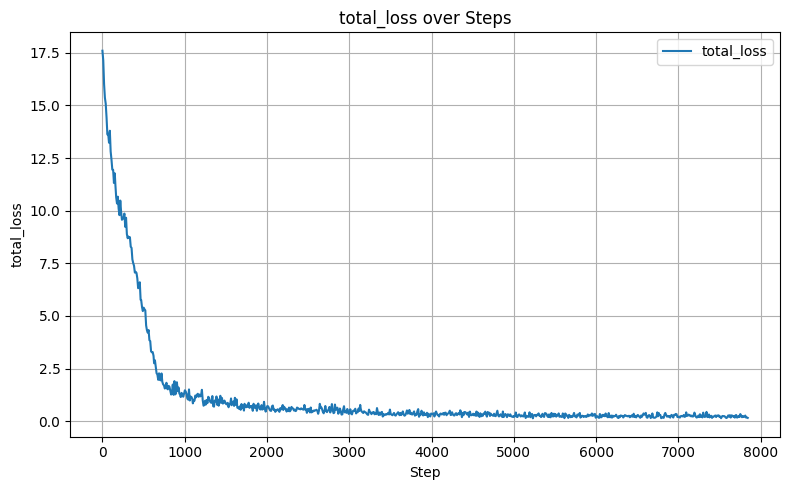

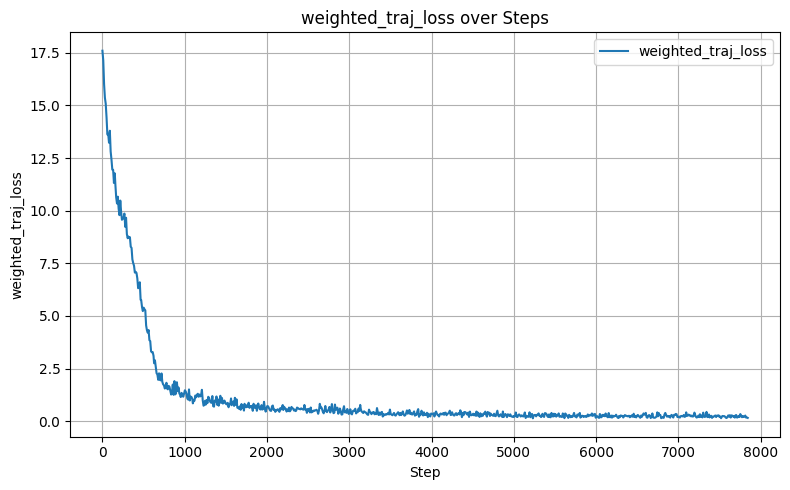

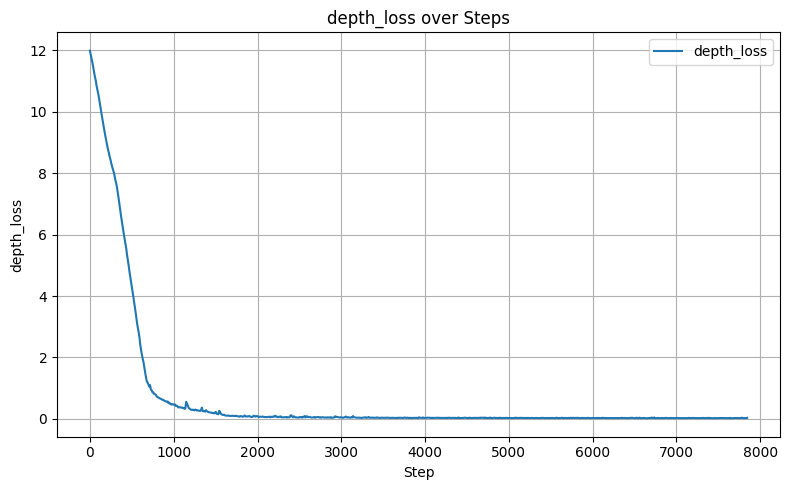

In [41]:
model = BetterDrivingPlanner( 
                 num_modes=6,
                 future_steps=60,
                 dropout_val=0.07,
                 use_layernorm=True,
                 use_depth_aux=True,
                 use_semantic_aux=False,
                 freeze_pretrained=True
                )

optimizer = optim.Adam(model.parameters(), lr=4.7e-04)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # halve lr every 20 epochs

logger = Logger()

train(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler=scheduler, 
    logger=logger, 
    num_epochs=50,
    lambda_depth=0.05,
    lambda_semantic=0.05
)




By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)



 You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.


Save your trained models here

In [13]:
# save the model
dir = 'models'
os.makedirs(dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(dir, "phase2_model_deep_1.65.pth"))

In [30]:
# load model
dir = 'models'
model = BetterDrivingPlanner( 
                 num_modes=6,
                 future_steps=60,
                 dropout_val=0.0,
                 use_layernorm=False,
                 use_depth_aux=True,
                 use_semantic_aux=True
                )
model.load_state_dict(torch.load(os.path.join(dir, "phase2_model_deep_2.pth")))

/tmp/ipykernel_64/921894434.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(dir, "phase2_model_deep_2.pth")))


<All keys matched successfully>

# 🔎 Inference Test 

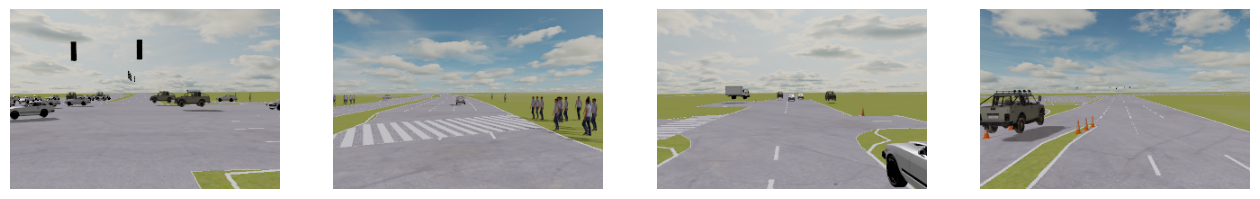

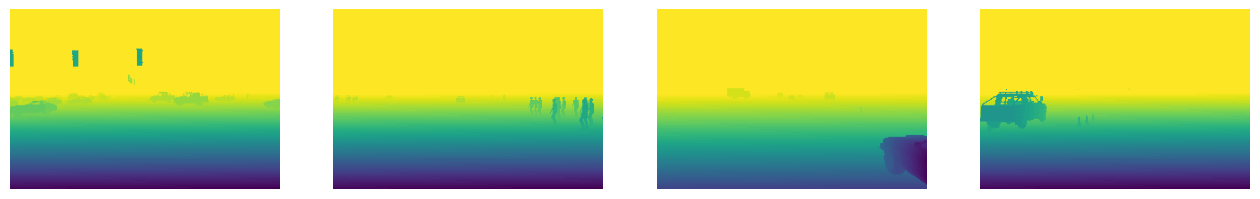

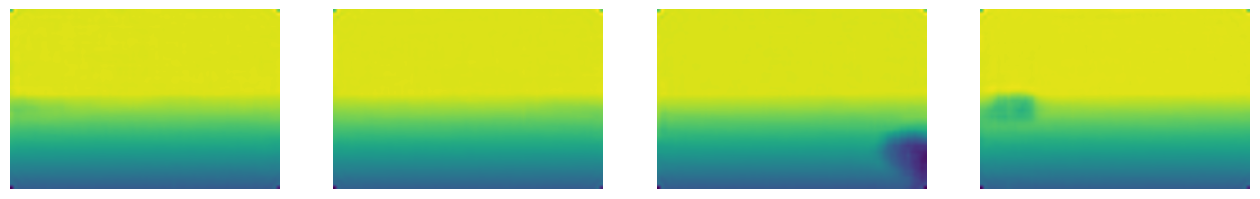

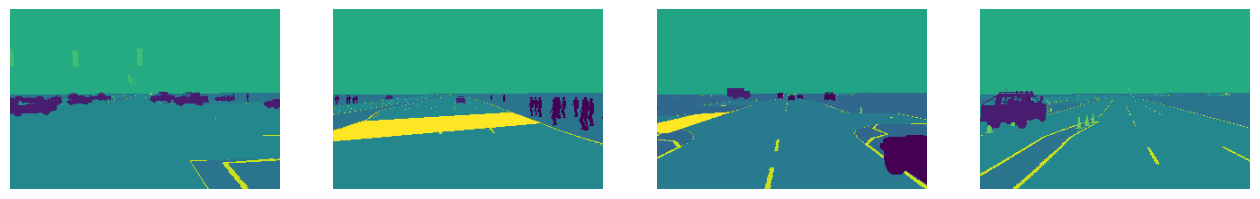

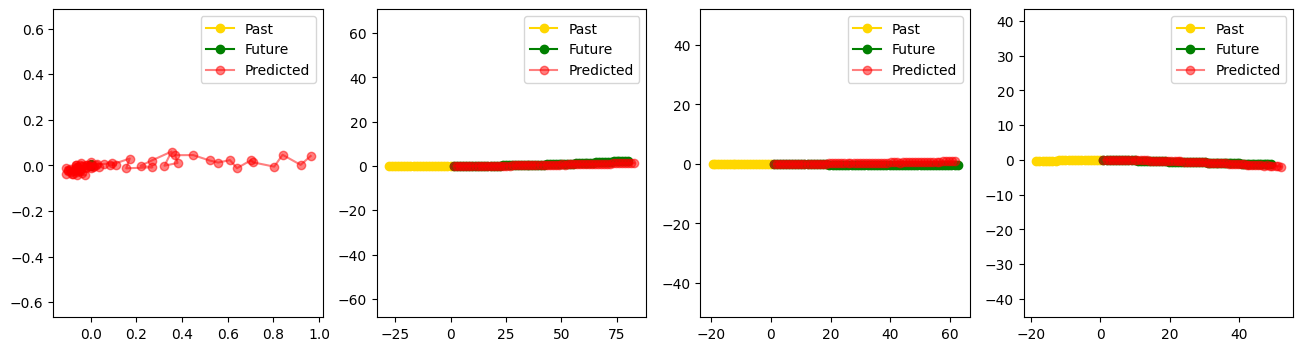

In [32]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)
depth = val_batch_zero['depth'].to(device)
semantic = val_batch_zero['semantic'].to(device)

model.eval()
with torch.no_grad():
    traj_pred, conf_pred, depth_pred, semantic_pred = model(camera, history)
    pred_future = model.predict_best(traj_pred, conf_pred)  

camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
depth = depth.cpu().numpy()
semantic = semantic.cpu().numpy()

pred_future = pred_future.cpu().numpy()
if depth_pred is not None:
    depth_pred = depth_pred.cpu().numpy()
if semantic_pred is not None:
    semantic_pred = semantic_pred.cpu().numpy()


k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0))
    axis[i].axis("off")
plt.show()

# plot the depth view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(depth[idx])
    axis[i].axis("off")
plt.show()

if depth_pred is not None:
    # plot the predicted depth of current step for the k examples
    fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
    for i, idx in enumerate(selected_indices):
        axis[i].imshow(depth_pred[idx])
        axis[i].axis("off")
    plt.show()

# plot the semantic view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(semantic[idx])
    axis[i].axis("off")
plt.show()

if semantic_pred is not None:
    # plot the predicted depth of current step for the k examples
    fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
    for i, idx in enumerate(selected_indices):
        axis[i].imshow(semantic_pred[idx].argmax(axis=-1))
        axis[i].axis("off")
    plt.show()


# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted", alpha=0.5)
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [28]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [46]:
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []

with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        traj_pred, conf_pred,_,_ = model(camera, history)
        pred_future = model.predict_best(traj_pred, conf_pred)  # (B, T, 2)
        all_plans.append(pred_future.cpu().numpy())  # move to CPU before storing
        
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
